In [1]:
import dask.dataframe as dd
import pandas as pd
import folium
import datetime
import numpy as np
import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import time
import datetime
import gpxpy.geo
from sklearn.cluster import MiniBatchKMeans,KMeans
import math 
import pickle 
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'  
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import warnings
warnings.filterwarnings("ignore")

In [2]:
month= dd.read_csv("yellow_tripdata_2015-01.csv")
print(month.columns)## Features in the dataset:



Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


# Data Information

<p>
Ge the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (2016 data)
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) 
</p>

## Information on taxis:

<h5> Yellow Taxi: Yellow Medallion Taxicabs</h5>
<p> These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.</p>

<h5> For Hire Vehicles (FHVs) </h5>
<p> FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged. </p>

<h5> Green Taxi: Street Hail Livery (SHL) </h5>
<p>  The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides. </p>
<p> Credits: Quora</p>

<h5>Footnote:</h5>
In the given notebook we are considering only the yellow taxis for the time period between Jan - Mar 2015 & Jan - Mar 2016

<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

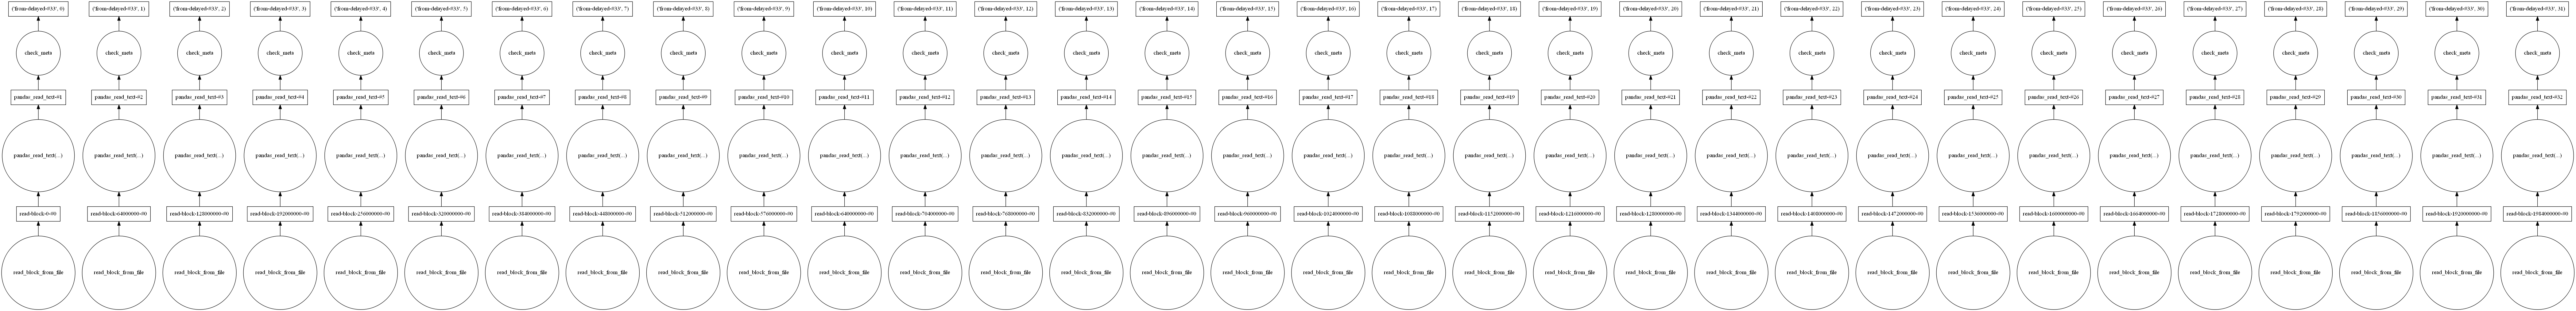

In [3]:
month.visualize()

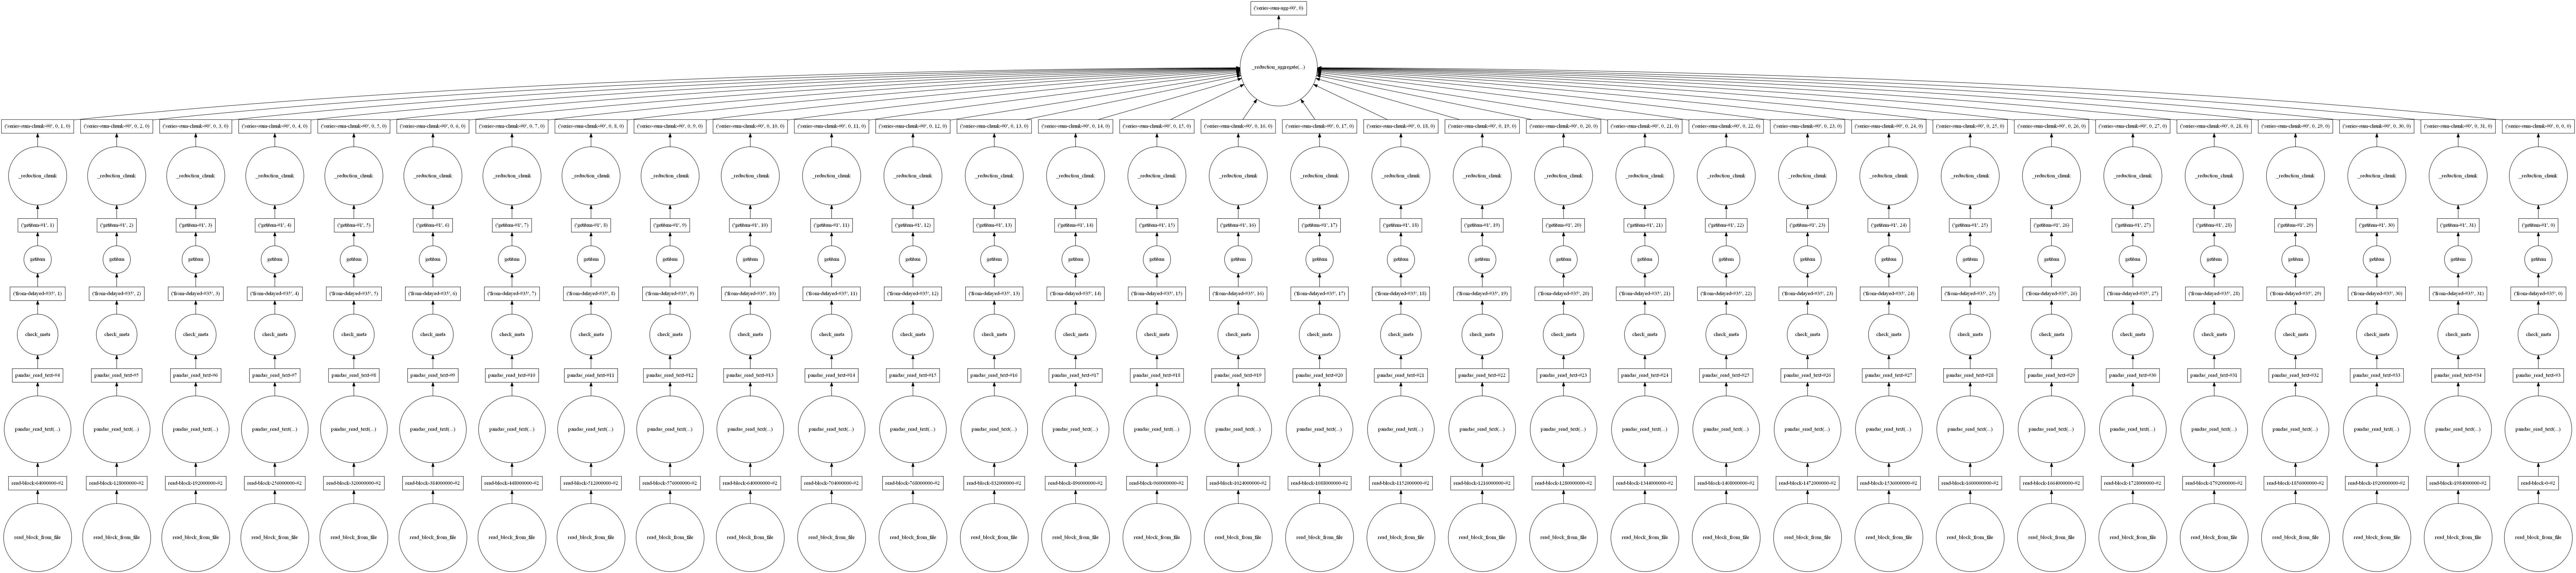

In [4]:
month.fare_amount.sum().visualize()

# ML Problem Formulation
<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.</i>
<p> 
To solve the above we would be using data collected in Jan - Mar 2015 to predict the pickups in Jan - Mar 2016.
</p>

# Performance metrics
1. Mean Absolute percentage error.
2. Mean Squared error.

## Data cleaning

In [5]:
month.head(5)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

### 1. Trip Duration

In [6]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
def return_with_trip_times(month):
    duration=month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    duration_pickup= [convert_to_unix(x) for x in duration["tpep_pickup_datetime"].values]
    duration_drop= [convert_to_unix(x) for x in duration["tpep_dropoff_datetime"].values]
    durations= (np.array(duration_drop)-np.array(duration_pickup))/float(60)
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude',"dropoff_longitude","dropoff_latitude",'total_amount']].compute()

    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(month)

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(y="trip_times",data= frame_with_durations)
plt.show()

#### Observations
    1. We find some outliers here. 
    2.Hence We shall remove them.

In [7]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [8]:
for i in range(0,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
1 percentile value is 1.2166666666666666
2 percentile value is 1.8833333333333333
3 percentile value is 2.2666666666666666
4 percentile value is 2.5833333333333335
5 percentile value is 2.8333333333333335
6 percentile value is 3.066666666666667
7 percentile value is 3.2666666666666666
8 percentile value is 3.466666666666667
9 percentile value is 3.65
100 percentile value is  548555.6333333333


In [9]:
for i in range(9980,10000):
    i= i/100
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

99.8 percentile value is 71.86666666666666
99.81 percentile value is 73.05
99.82 percentile value is 74.41666666666667
99.83 percentile value is 75.91666666666667
99.84 percentile value is 77.6
99.85 percentile value is 79.66666666666667
99.86 percentile value is 81.93333333333334
99.87 percentile value is 84.8
99.88 percentile value is 88.53333333333333
99.89 percentile value is 93.56666666666666
99.9 percentile value is 101.6
99.91 percentile value is 120.1
99.92 percentile value is 226.18333333333334
99.93 percentile value is 647.2
99.94 percentile value is 1298.0666666666666
99.95 percentile value is 1413.4
99.96 percentile value is 1427.3
99.97 percentile value is 1432.95
99.98 percentile value is 1436.0666666666666
99.99 percentile value is 1438.0833333333333
100 percentile value is  548555.6333333333


In [10]:
frame_with_durations_modified= frame_with_durations[(frame_with_durations.trip_times>1)&(frame_with_durations.trip_times<720)]

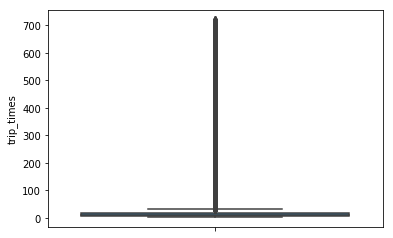

In [11]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

#### Observations
    1. We find some outliers here. 
    2.Hence We shall remove them.

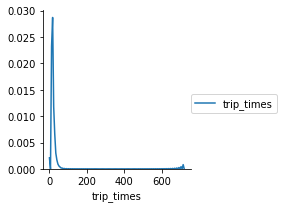

In [12]:
sns.FacetGrid(frame_with_durations_modified,size=3).map(sns.kdeplot, "trip_times").add_legend()
plt.show()

#### Observations
    1. We find that majority of the trips are under 100 minutes.
    2. It seems like a log normal distribution.

In [13]:
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

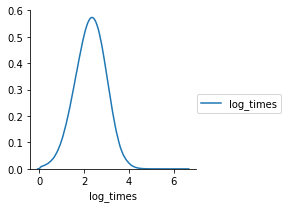

In [14]:
sns.FacetGrid(frame_with_durations_modified,size=3).map(sns.kdeplot,"log_times").add_legend()
plt.show()

#### Observations
    1. After applying log to the values,we obtain a gaussian distribution.

### 2. Speed

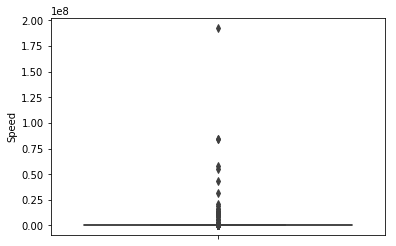

In [15]:
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed",data= frame_with_durations_modified)
plt.show()

#### Observations
    1. We find some outliers here. 
    2.Hence We shall remove them.

In [16]:
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [17]:
for i in range(990,1000):
    i=i/10
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [18]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [19]:
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

### The average speed is 11.73 MPH

### Trip Distance

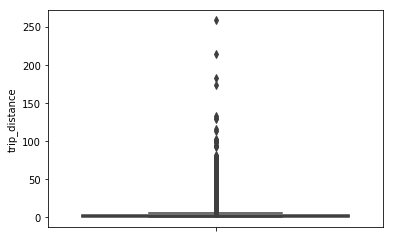

In [20]:
sns.boxplot(y="trip_distance", data=frame_with_durations_modified)
plt.show()

#### Observations
    1. We find some outliers here. 
    2.Hence We shall remove them.

In [21]:
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [22]:
for i in range(9990,10000):
    i=i/100
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

99.9 percentile value is 22.57
99.91 percentile value is 22.86
99.92 percentile value is 23.24
99.93 percentile value is 23.8
99.94 percentile value is 24.5
99.95 percentile value is 25.5
99.96 percentile value is 26.7
99.97 percentile value is 28.1
99.98 percentile value is 29.6
99.99 percentile value is 33.9
100 percentile value is  258.9


In [23]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<36)]

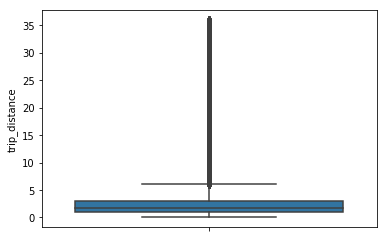

In [24]:
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

#### Observations
    1. After removing the outliers, we find that the majority of the people travel less than 5 miles using cab 

### Total Fare

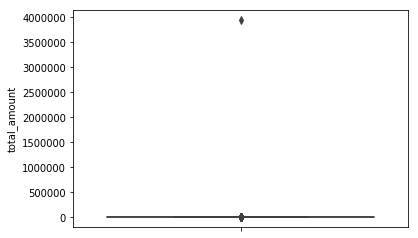

In [25]:
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

#### Observations
    1. We find some outliers here. 
    2.Hence We shall remove them.

In [26]:
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [27]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 68.0
99.1 percentile value is 69.05
99.2 percentile value is 69.6
99.3 percentile value is 69.69
99.4 percentile value is 69.73
99.5 percentile value is 69.76
99.6 percentile value is 72.46
99.7 percentile value is 72.66
99.8 percentile value is 79.13
99.9 percentile value is 94.0
100 percentile value is  3950611.6


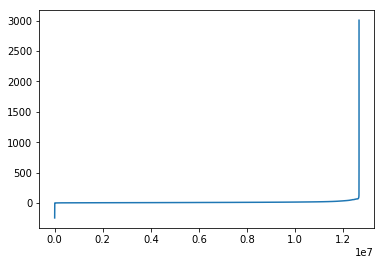

In [28]:
plt.plot(var[:-2])
plt.show()

#### Observations
    1. We find that the graph sharply increases after 1000

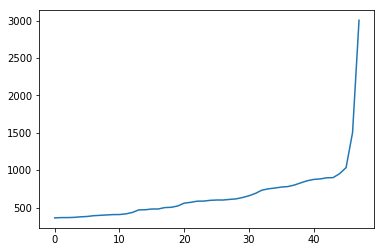

In [29]:
plt.plot(var[-50:-2])
plt.show()

#### Observations
    1. We remove the last two values from the graph to make it smooth

### Passenger Count

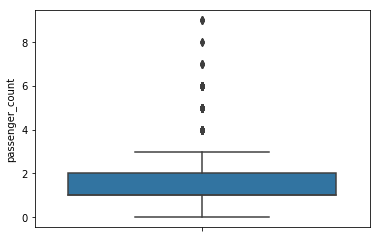

In [91]:
#box-plot after removal of outliers
sns.boxplot(y="passenger_count", data =frame_with_durations_modified)
plt.show()

### Observation
    1. We find some outliers here.
    2. We can remove the data with outliers here

In [94]:
for i in range(0,100,10):
    var =frame_with_durations_modified["passenger_count"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0
10 percentile value is 1
20 percentile value is 1
30 percentile value is 1
40 percentile value is 1
50 percentile value is 1
60 percentile value is 1
70 percentile value is 1
80 percentile value is 2
90 percentile value is 4
100 percentile value is  9


In [97]:
for i in range(99990,100000,1):
    i=i/1000
    var =frame_with_durations_modified["passenger_count"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

99.99 percentile value is 6
99.991 percentile value is 6
99.992 percentile value is 6
99.993 percentile value is 6
99.994 percentile value is 6
99.995 percentile value is 6
99.996 percentile value is 6
99.997 percentile value is 6
99.998 percentile value is 6
99.999 percentile value is 6
100 percentile value is  9


#### Hence we can choose our threshold value as 6 for passenger count

### 4. Pickup Latitude and Pickup Longitude

In [ ]:
# Plotting pickup cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

### 5. Dropoff Latitude & Dropoff Longitude

In [ ]:
# Plotting dropoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

In [32]:
def remove_outliers(new_frame):
    a= new_frame.shape[0]
    print("number of pickup records= ",a)
    temp_frame= new_frame[(new_frame.trip_times>0) & (new_frame.trip_times<720)]
    b= temp_frame.shape[0]
    print("Number of outliers from trip time analysis",a-b)
    temp_frame=new_frame[(new_frame.trip_distance>0) & (new_frame.trip_distance<36)]
    c= temp_frame.shape[0]
    print("Number of outlier from trip distance analysis",a-c)
    temp_frame= new_frame[(new_frame.Speed>0) & (new_frame.Speed<45.31)]
    d= temp_frame.shape[0]
    print("Number of outliers from trip speed analysis: ",a-d)
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-e))
    
    
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    f = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-f))
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.passenger_count>0) & (new_frame.passenger_count<6)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 36)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame
 
    

In [33]:
print ("Removing outliers in the month of Jan-2018")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2018
----
number of pickup records=  12748986
Number of outliers from trip time analysis 23889
Number of outlier from trip distance analysis 81025
Number of outliers from trip speed analysis:  101830
Number of outliers from fare analysis: 5275
Number of outlier coordinates lying outside NY boundaries: 293919
Total outliers removed 370793
---
fraction of data points that remain after removing outliers 0.9709158830357175


## Data Preparation

In [34]:
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            


On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  0.9094046171704171 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.66207837991332 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5100829598655263 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 31.0 
Min inter-cluster distance = 

In [35]:
# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

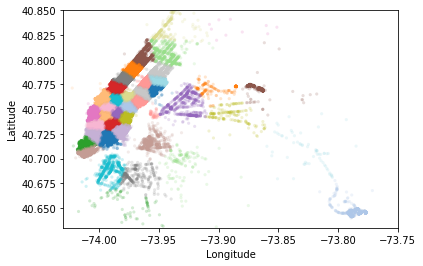

In [36]:
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

### Observation
    1. We've formed the clusters using latitude and longitude coordinates.
    2. They form in the shape of new york map.
    3. The the densely concentrated region can be seen as manhattan

In [37]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [38]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [39]:
jan_2015_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  pickup_cluster  pickup_bins  
0  1.421329e+09   5.285319              27         2130  
1  1.420902e+09   9.983193              18         1419  
2  1.420902e+09  10.746269              21         1419  
3  1.420902e+09  16.071429               8         1419  
4  1.420902e+09   9.318378              34         1419

In [40]:
# hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
jan_2015_groupby.head(5)

trip_distance
pickup_cluster pickup_bins               
0              1                      165
               2                      282
               3                      274
               4                      263
               5                      283

In [41]:
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
number of pickup records=  10906858
Number of outliers from trip time analysis 27190
Number of outlier from trip distance analysis 65863
Number of outliers from trip speed analysis:  84020
Number of outliers from fare analysis: 4991
Number of outlier coordinates lying outside NY boundaries: 214677
Total outliers removed 288961
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
number of pickup records=  11382049
Number of outliers from trip time analysis 27670
Number of outlier from trip distance analysis 69241
Number of outliers from trip speed analysis:  87579
Number of outliers from fare analysis: 5476
Number of outlier coordinates lying outside NY boundaries: 223161
Total outliers removed 300372
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
number of pickup records=  12210952
Number of outliers from trip time analysis 30868
Number of outlier from trip distance a

In [42]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [43]:

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [44]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  33
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  35
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  149
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  32
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  261
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  41
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  42
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  43
-----------

In [45]:
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [46]:
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):#cluster iteration
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):#bin iteration
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [47]:
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [48]:
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  178560


In [49]:
jan_2015_groupby['trip_distance'].values

array([165, 282, 274, ...,   2,   1,   3], dtype=int64)

In [50]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 13104

## Time series and Fourier Transforms

cluster  1


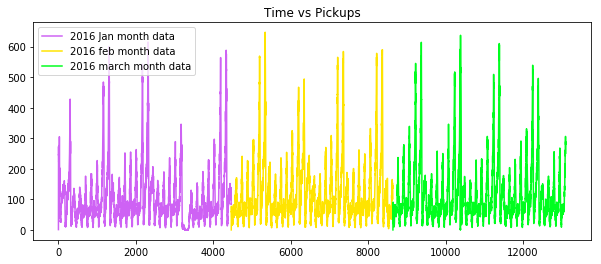

cluster  2


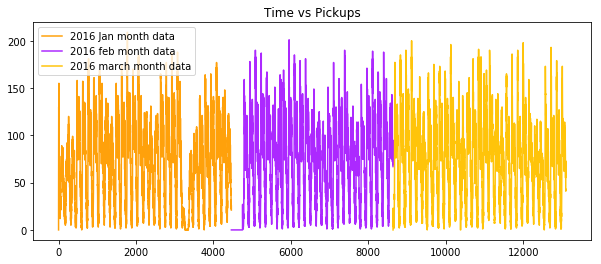

cluster  3


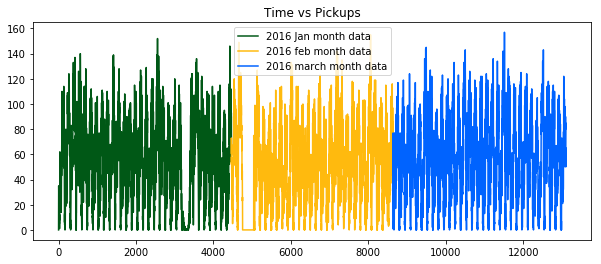

cluster  4


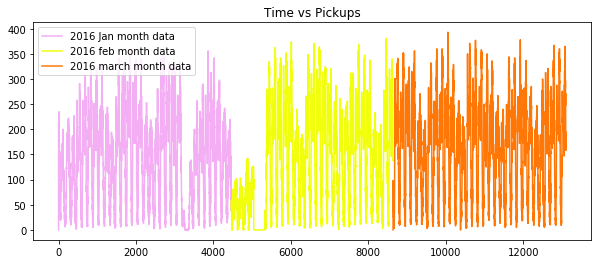

cluster  5


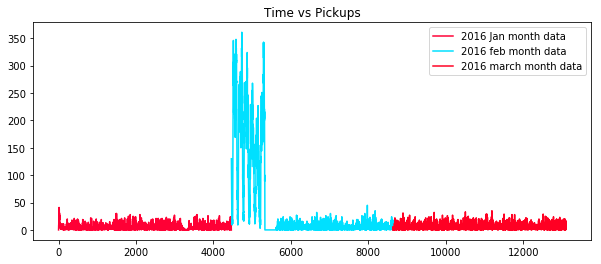

cluster  6


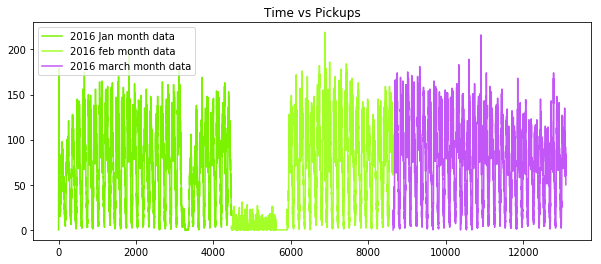

cluster  7


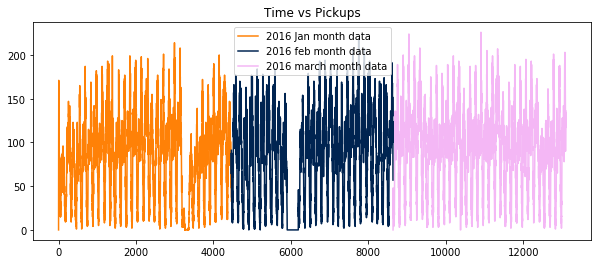

cluster  8


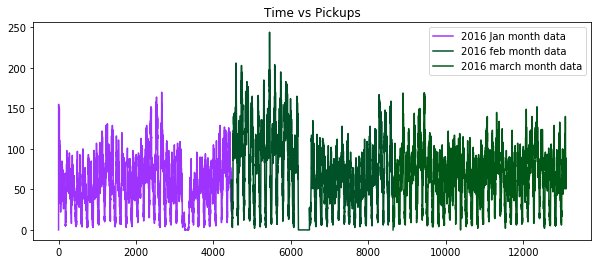

cluster  9


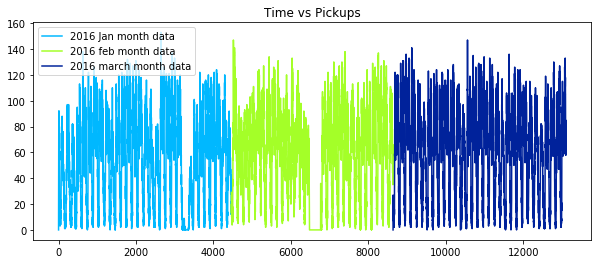

cluster  10


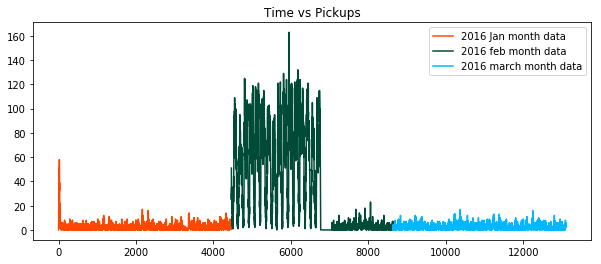

cluster  11


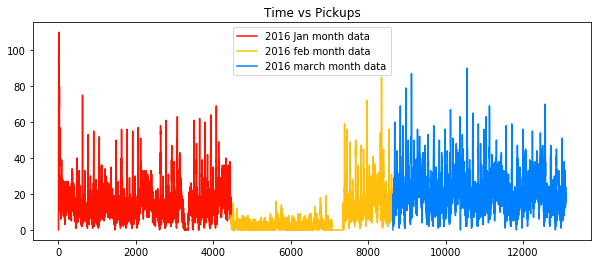

cluster  12


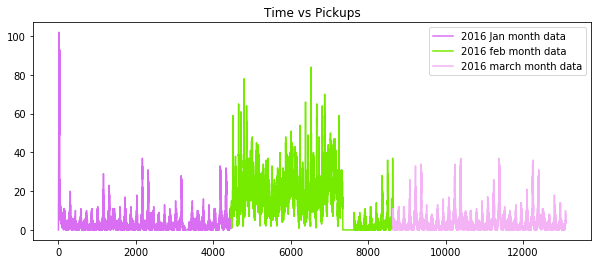

cluster  13


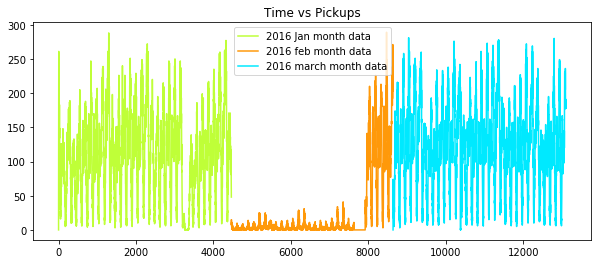

cluster  14


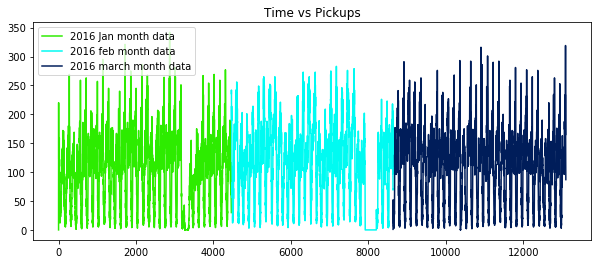

cluster  15


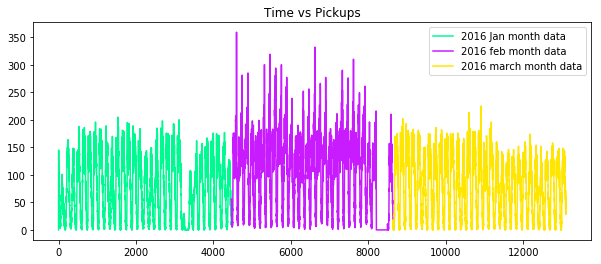

cluster  16


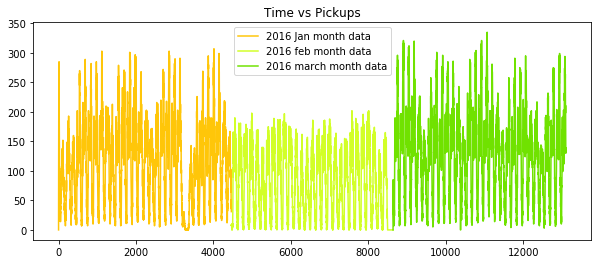

cluster  17


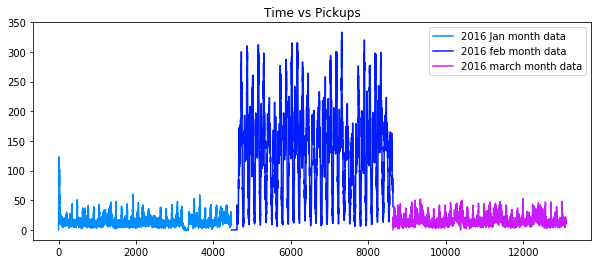

cluster  18


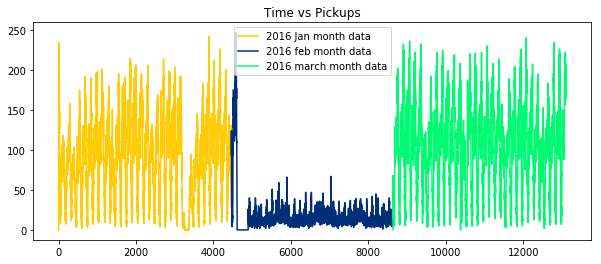

cluster  19


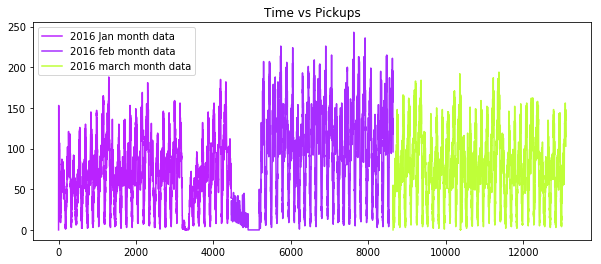

cluster  20


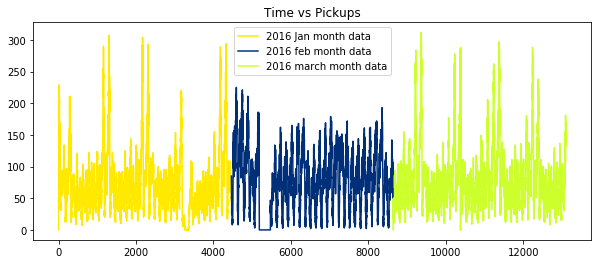

cluster  21


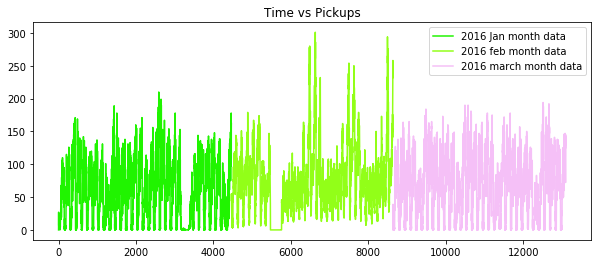

cluster  22


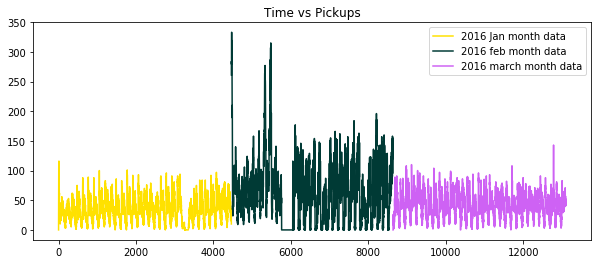

cluster  23


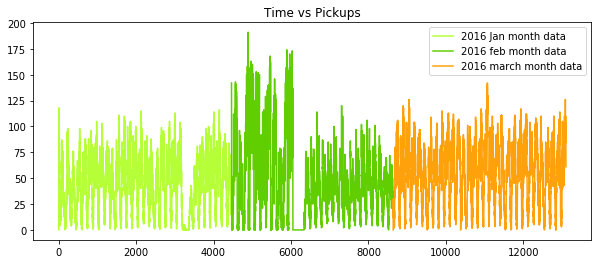

cluster  24


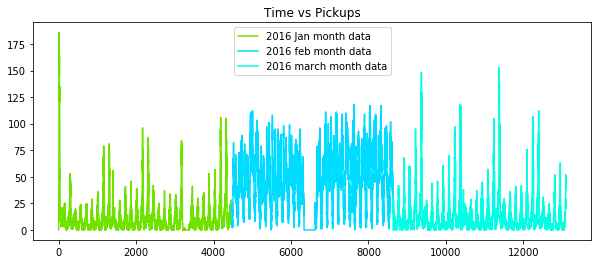

cluster  25


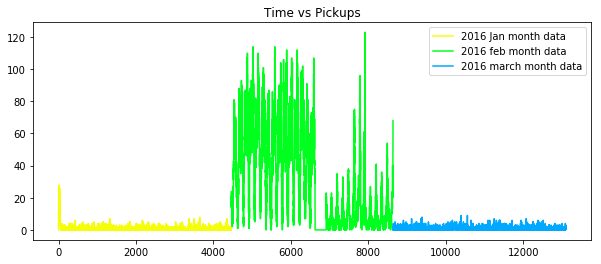

cluster  26


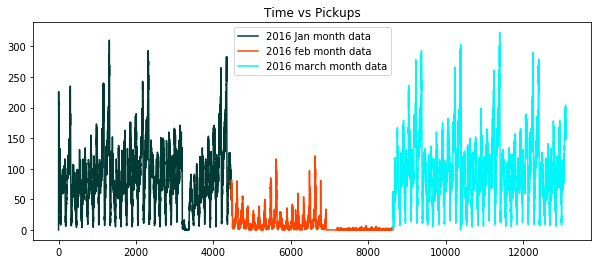

cluster  27


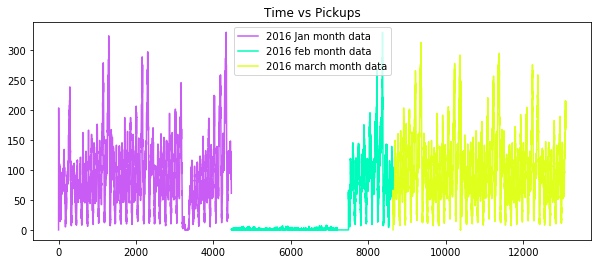

cluster  28


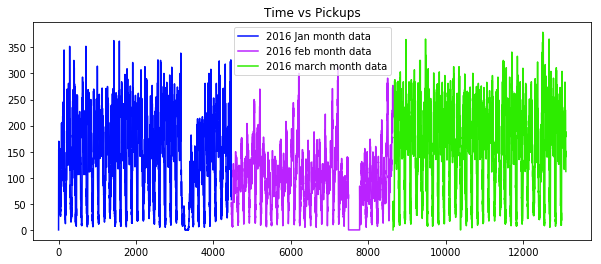

cluster  29


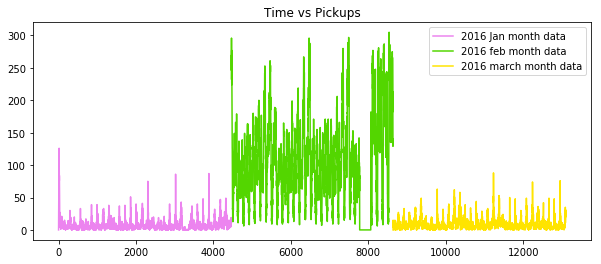

cluster  30


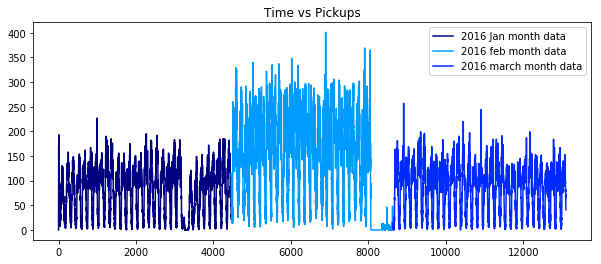

cluster  31


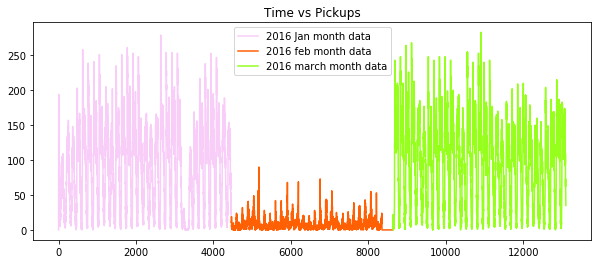

cluster  32


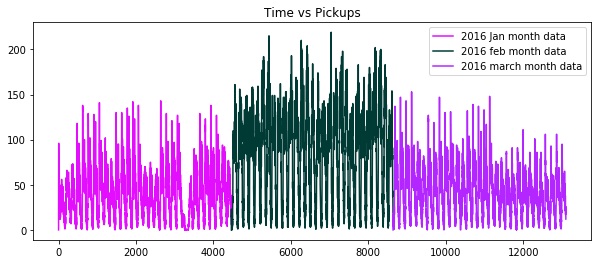

cluster  33


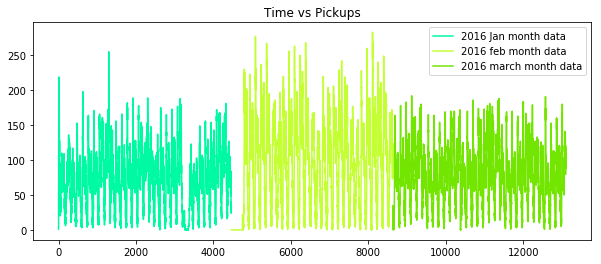

cluster  34


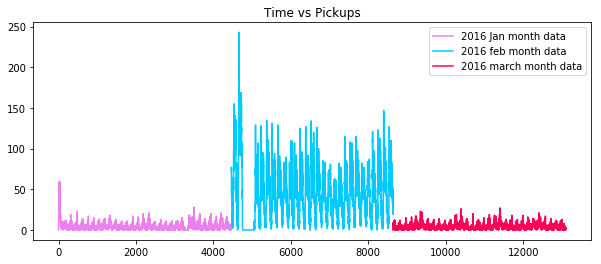

cluster  35


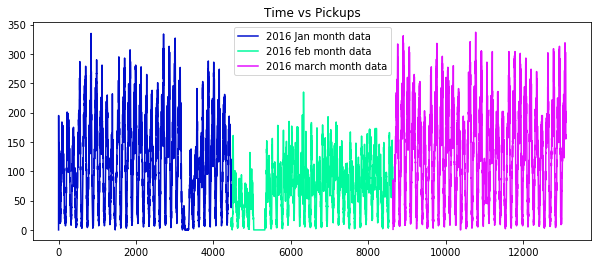

cluster  36


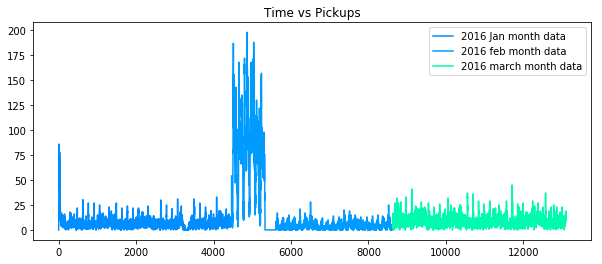

cluster  37


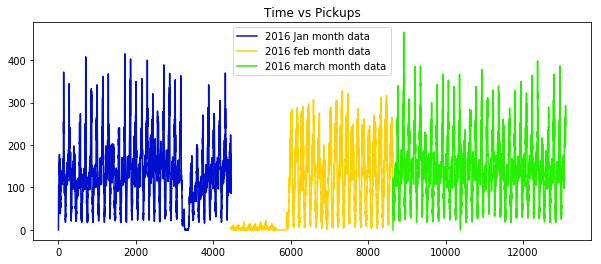

cluster  38


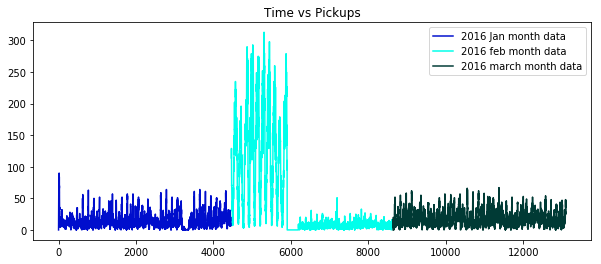

cluster  39


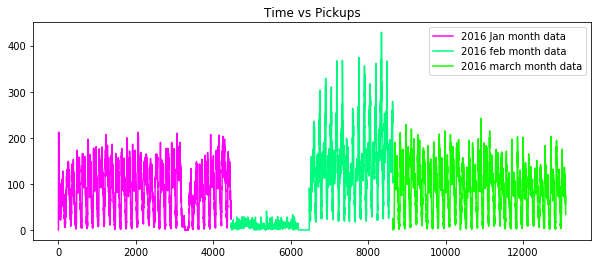

cluster  40


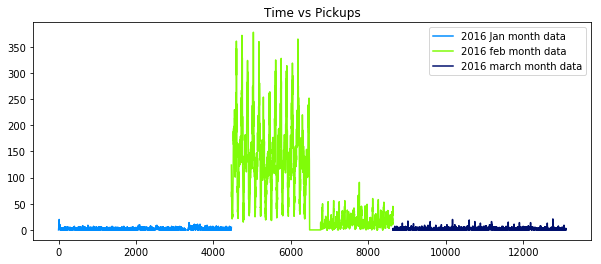

In [88]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(40):
    print("cluster ",i+1)
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.title("Time vs Pickups")
    plt.legend()
    plt.show()

### Observation
    1. We've plotted pickups for each cluster in months of january,february and march.
    2. We'll analyse this using fast fourier transforms.
    3. There are repititons in the waves, which we'll discuss after fast fourier transformation

## Fourier Transform

In [ ]:
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
#print(np.abs(Y)[0:100])
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

cluster 1


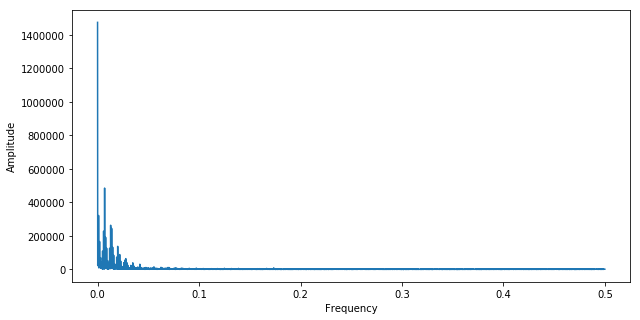

cluster 2


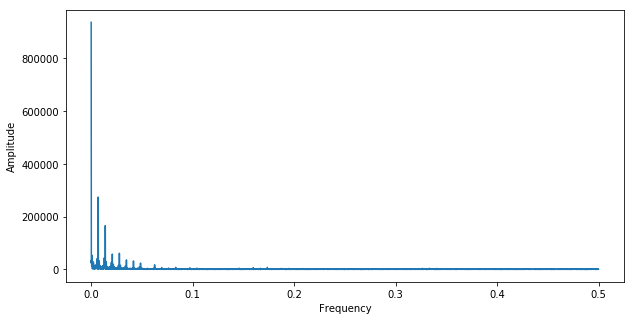

cluster 3


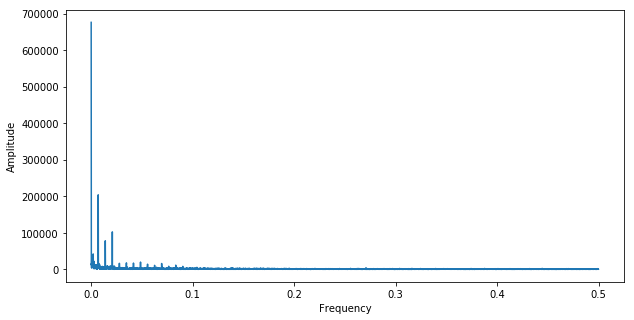

cluster 4


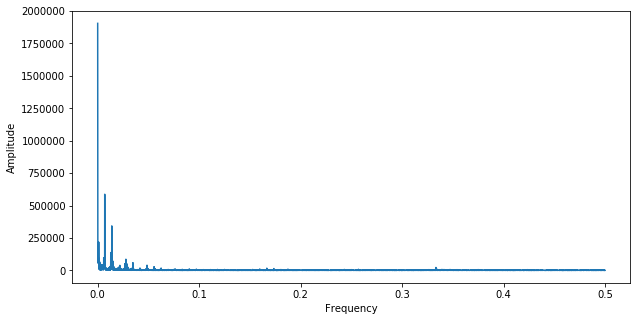

cluster 5


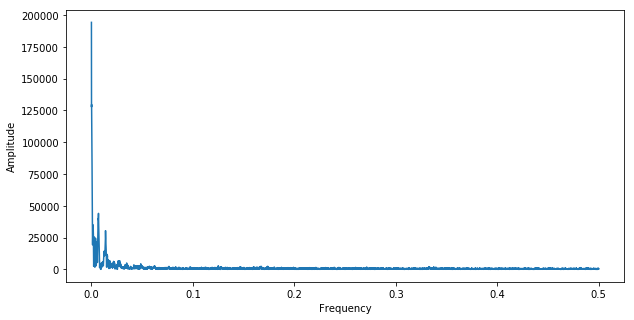

cluster 6


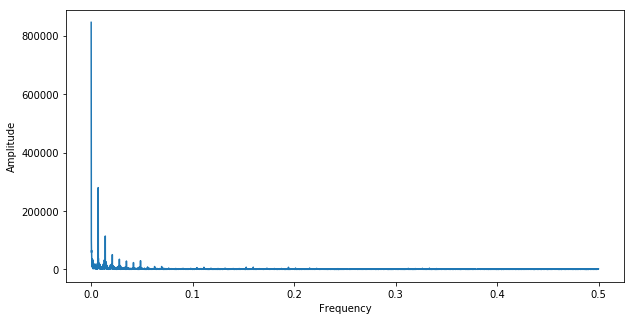

cluster 7


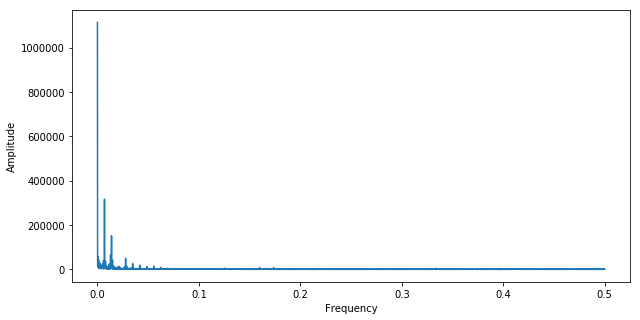

cluster 8


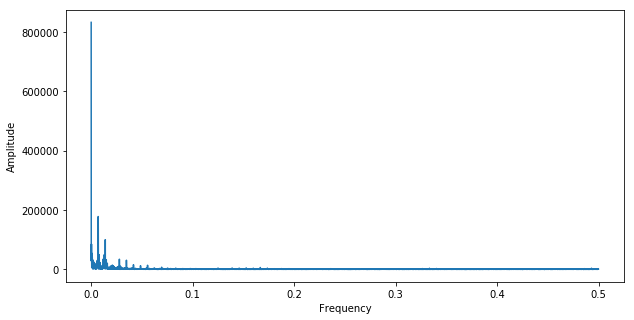

cluster 9


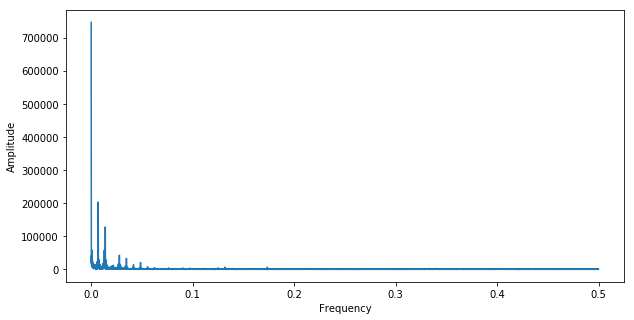

cluster 10


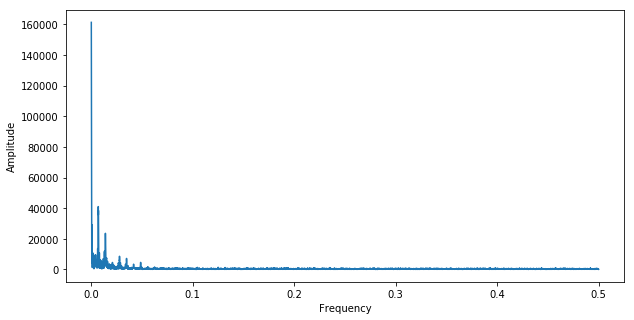

cluster 11


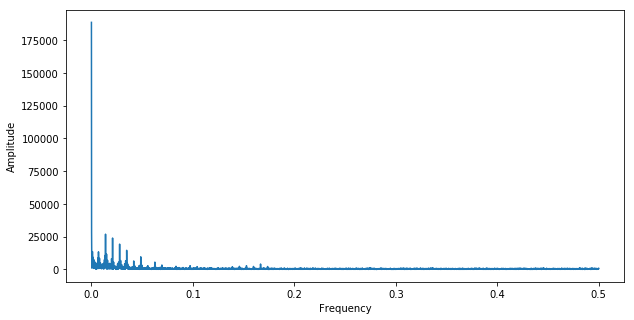

cluster 12


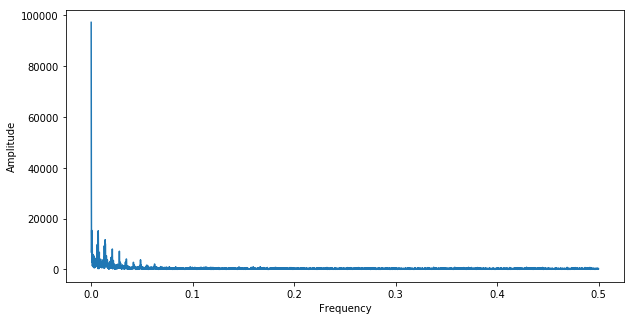

cluster 13


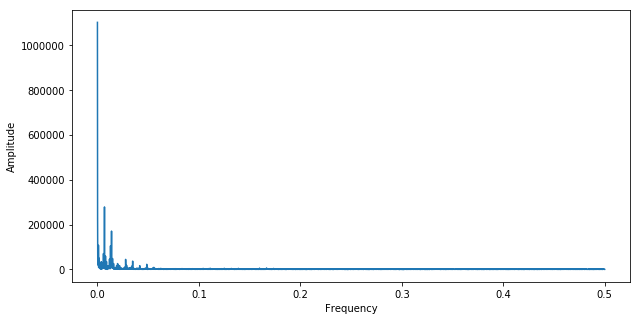

cluster 14


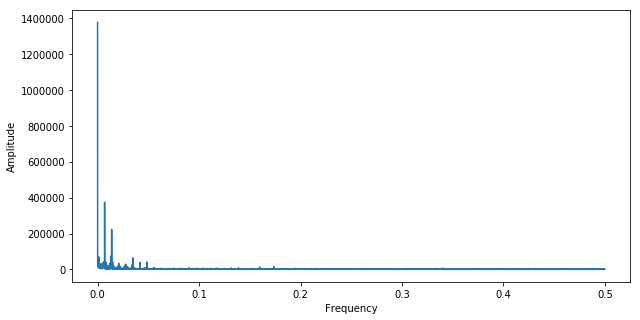

cluster 15


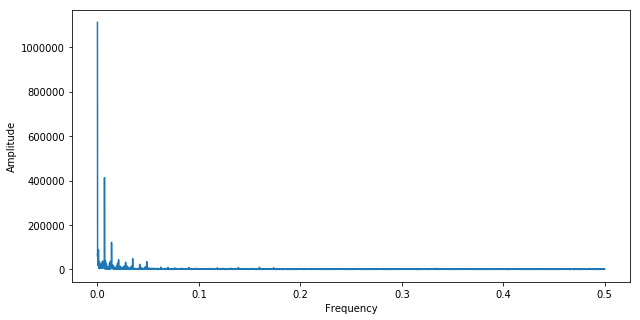

cluster 16


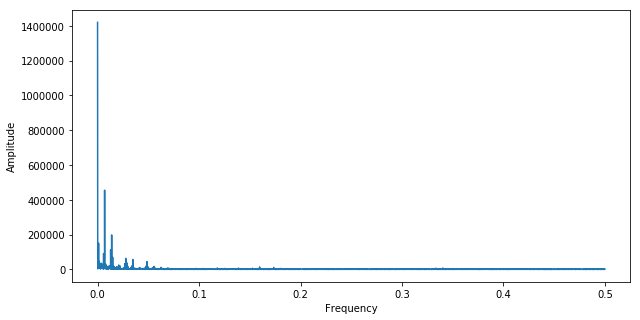

cluster 17


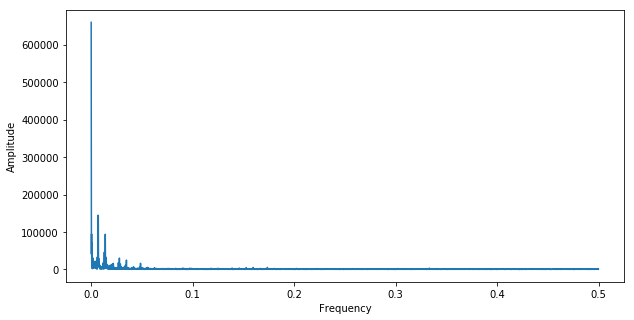

cluster 18


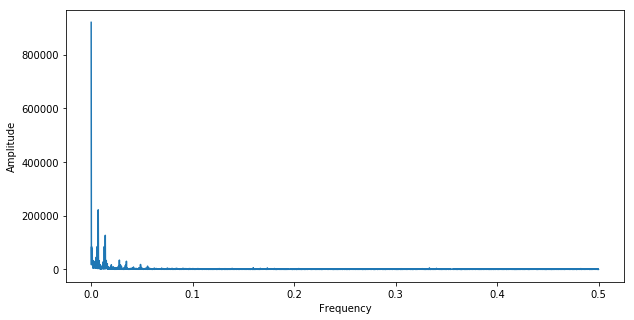

cluster 19


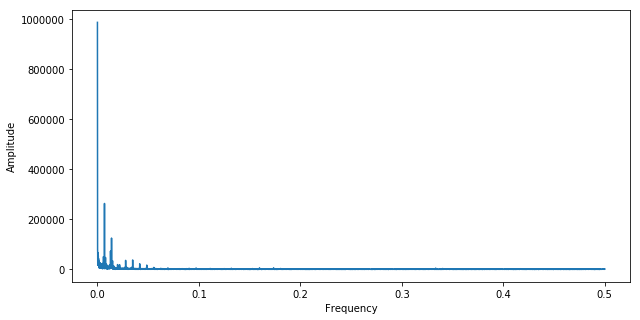

cluster 20


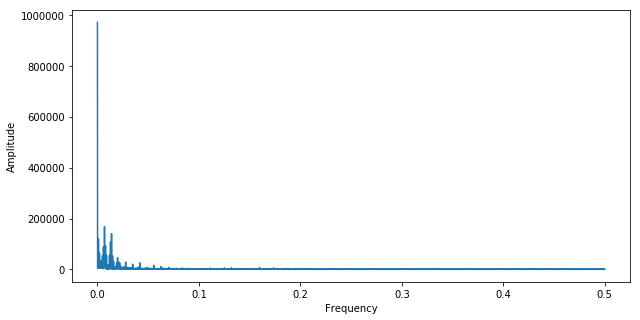

cluster 21


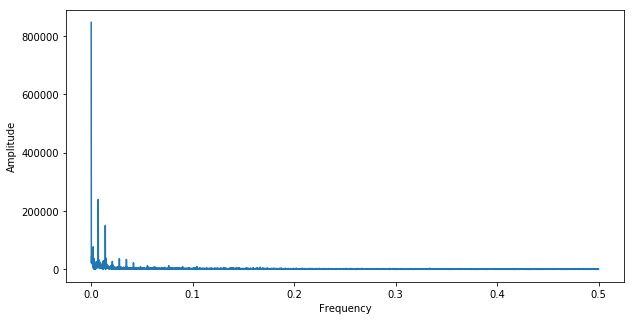

cluster 22


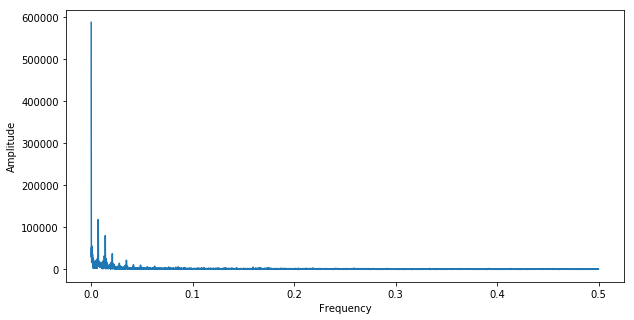

cluster 23


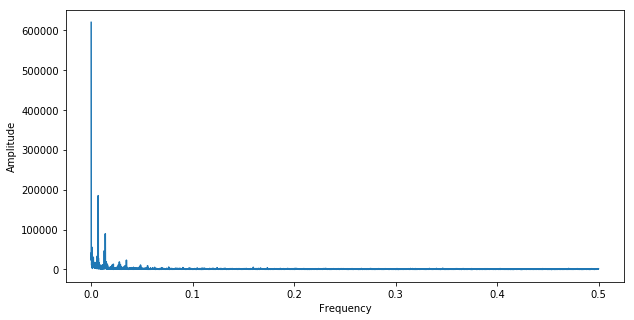

cluster 24


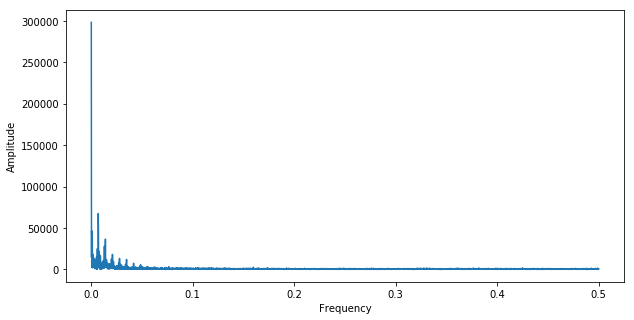

cluster 25


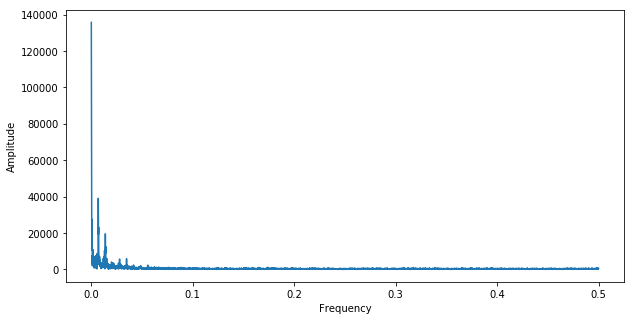

cluster 26


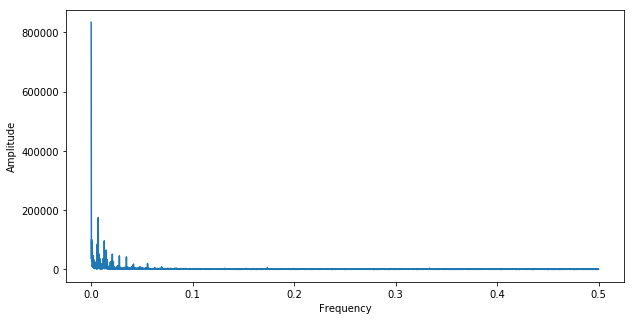

cluster 27


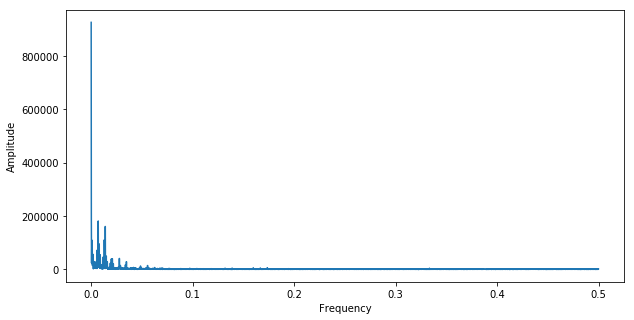

cluster 28


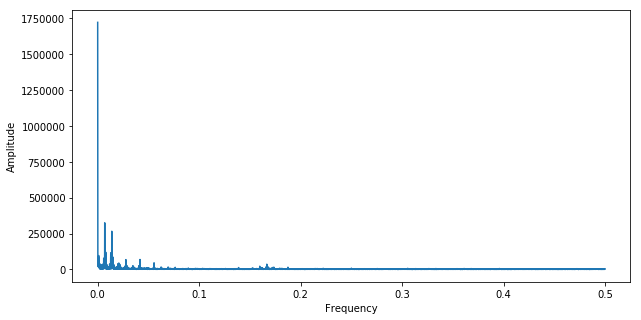

cluster 29


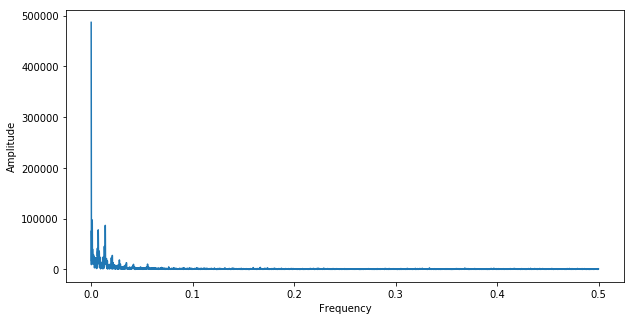

cluster 30


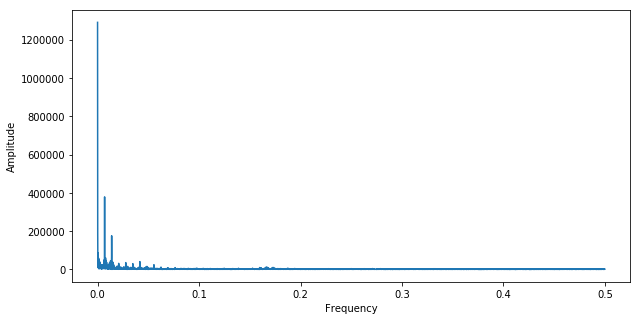

cluster 31


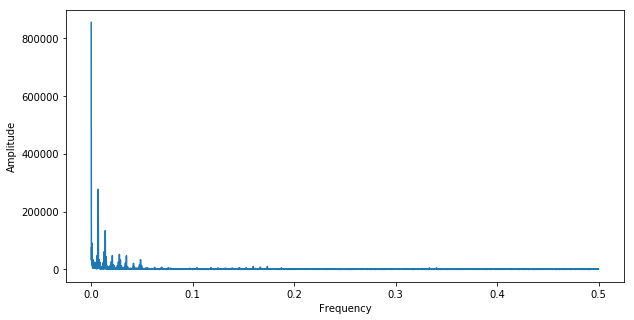

cluster 32


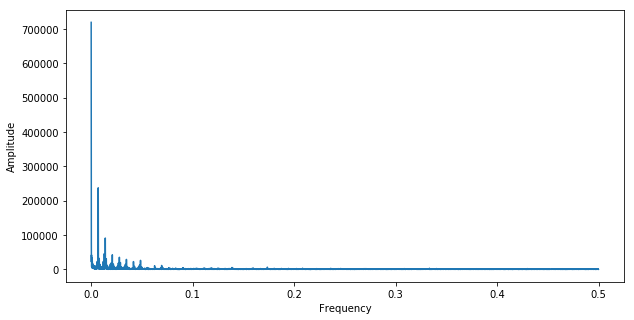

cluster 33


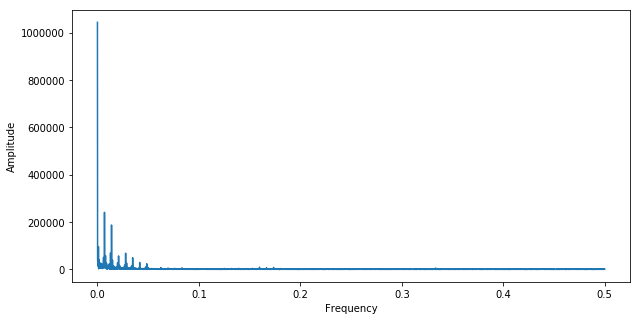

cluster 34


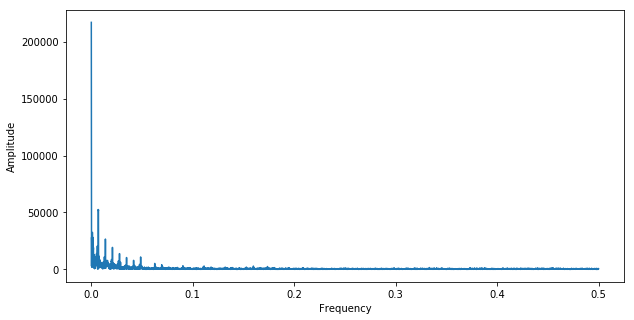

cluster 35


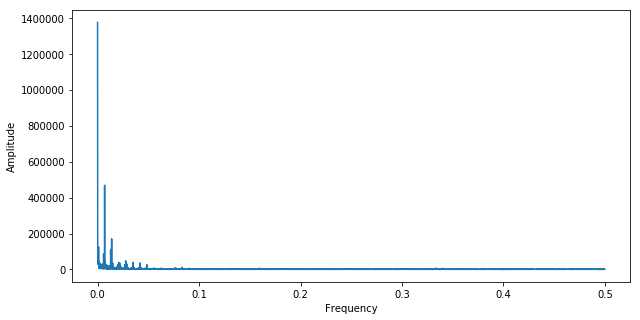

cluster 36


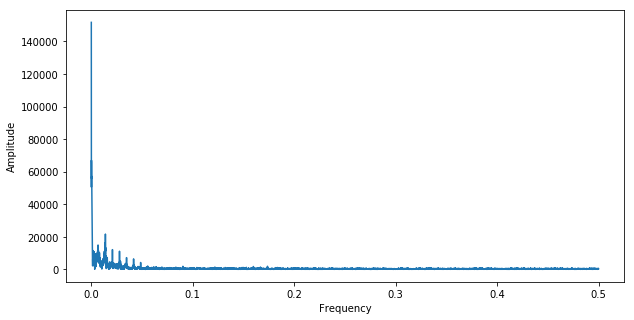

cluster 37


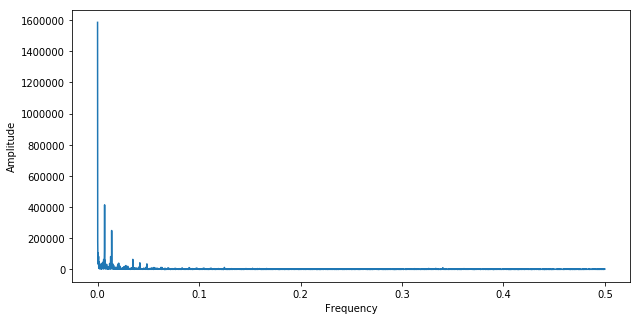

cluster 38


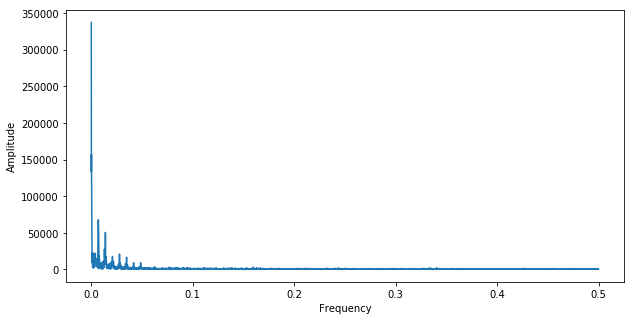

cluster 39


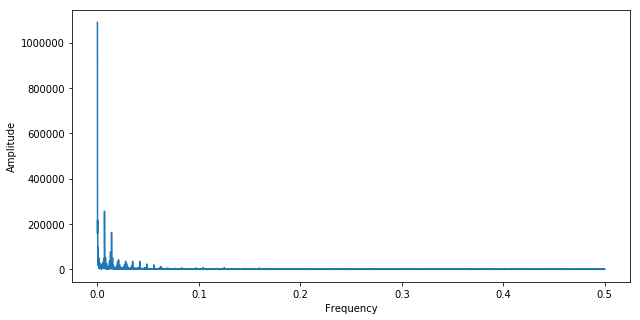

cluster 40


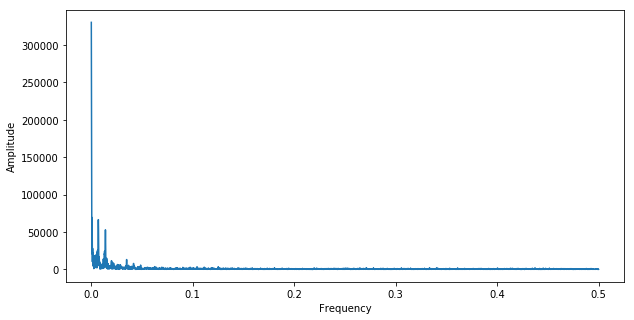

In [85]:
for i in range(40):
    print("cluster",i+1)
    Y  = np.abs(np.fft.fft(regions_cum[i][0:13104]))
    # read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
    freq = np.fft.fftfreq(13104, 1)
    n = len(freq)
    #print(np.abs(Y)[0:100])
    plt.figure(figsize=(10,5))
    plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()

### Observation
    1, We've the following graph using fast fourier transform and plotted its frequencies and amplitudes.
    2. This graphs are obtained for the month of january,febrauary and march
    2. Since the phase is not zero for the signal, we'll obtain a spike at the center.
    3. It is known as DC component of the wave.
    4. We can observe several frequencies here.
    5. The frequency at 1/144 is the frequency of pickups for every 24 hours.
    6. We can assume this as one cycle of wave where drastically increase from midnight to morning, drop a little, 
       increase in the evenings and drastically drop at night finally.
    7. The second spike can be seen at 1/72 meaning it's capturing pickups at busy hours.
    8. We'll ignore the DC component of the wave.
    9. We've plotted graphs for all the clusters

In [53]:
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [54]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [55]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

### Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [56]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [57]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### Exponential  Weighted Moving Averages
 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [58]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [59]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [60]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

### Forecasting using ARIMA Model

A popular and widely used statistical method for time series forecasting is the ARIMA model. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.
The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

In [167]:
from pandas import read_csv #https://www.quora.com/How-can-I-do-step-by-step-time-series-ARIMA-analysis-in-Python
from pandas import datetime#https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
final_test=[]
predictions = list()
for i in range(0,40): 
    X = jan_2016_smooth[i*4464:4464*(i+1)]
    size = int(len(X) * 0.90)
    train, test = X[0:size], X[size:len(X)]
    final_test.extend(test)
    history = [x for x in train]
    
    for t in range(len(test)):
        model = ARIMA(history, order=(10,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

error = mean_squared_error(final_test, predictions)
mape= (mean_absolute_error(final_test, predictions))/(sum(final_test)/len(final_test))
print("The MAPE is given as: ",mape)
print("The MSE is given as:",error)

The MAPE is given as:  0.11829176030018547
The MSE is given as: 137.21053735721242


### Method of Solving
    1. We can use the forecast() function on the ARIMAResults object to make predictions which performs a one-step 
       forecast using the model.
    2. We can split the training dataset into train and test sets, use the train set to fit the model, and generate a
       prediction for each element on the test set.
    3. A rolling forecast is required given the dependence on observations in prior time steps for differencing and 
       the AR model. A way to perform this rolling forecast is to re-create the ARIMA model after each new observation
       is received.
    4. We manually keep track of all observations in a list called history that is seeded with the training data and to 
       which new observations are appended each iteration.
    5. We perform this for all the clusters and calculate the MAPE and MSE value.
    6. Here, we are using 2016 Jan data itself to predict the values.
    7. Ideally the last 5%-10% of data ordered in time would be ideal for testing.
    8. We can apply this model for all the months similarly.
    9. We can configure the paramters with different methods to improve the MAPE value.

## Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [61]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []
tsne_month=[]

tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [62]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [63]:
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [64]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [65]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 40 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 40 Number of data points in test data 3930 Each data point contains 5 features


In [66]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


## Incorporating fourier features

#### Method:
    1. we will calculate the frequency and amplitude for each cluster using numpy fast fourier transforms.
    2. As analysed in the graph, the values of each cluster the fourier frequencies and amplitude will be same.
    3. We will take the top 5 five frequencies and amplitudes and append it with dataframe formed above.


In [67]:
#https://stackoverflow.com/questions/37049887/print-highest-peak-value-of-the-frequency-domain-plot
fft_list=[]
freq_list=[]
fft_values=[]
freq_values=[]
from tqdm import tqdm
for i in tqdm(range(0,40)):
    fft_values=[]
    freq_values=[]
    Y1    = np.abs(np.fft.fft(regions_cum[i][:13104]))  
    freq1 = np.abs(np.fft.fftfreq(13104, 1))
    indices_fft = np.argsort(-Y1)[1:]
    for i1 in range(0,9,2):
        fft_values.append(Y1[indices_fft[i1]])
        freq_values.append(freq1[indices_fft[i1]])
    for i2 in range(0,13099):
        fft_list.append(fft_values)
        freq_list.append(freq_values)
        

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.17it/s]


In [68]:
fft_train =  [fft_list[i*13099:(13099*i+9169)] for i in range(0,40)]
fft_test = [fft_list[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

freq_train =  [freq_list[i*13099:(13099*i+9169)] for i in range(0,40)]
freq_test = [freq_list[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]


In [69]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [70]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [71]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [72]:
fft_train_new_features = []
fft_test_new_features=[]
freq_train_new_features = []
freq_test_new_features=[]
for i in range(0,40):
    fft_train_new_features.extend(fft_train[i])
    freq_train_new_features.extend(freq_train[i])
for i in range(0,40):
    fft_test_new_features.extend(fft_test[i])
    freq_test_new_features.extend(freq_test[i]) 

In [73]:
fft_train_new_features1 =np.array(fft_train_new_features) 
fft_test_new_features1=np.array(fft_test_new_features)
freq_train_new_features1 = np.array(freq_train_new_features)
freq_test_new_features1=np.array(freq_test_new_features)

In [74]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [75]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [76]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg
df_train['frequency 1'] = fft_train_new_features1[:,0:1]
df_train['amplitude 1'] = freq_train_new_features1[:,0:1]
df_train['frequency 2'] = fft_train_new_features1[:,1:2]
df_train['amplitude 2'] = freq_train_new_features1[:,1:2]
df_train['frequency 3'] = fft_train_new_features1[:,2:3]
df_train['amplitude 3'] = freq_train_new_features1[:,2:3]
df_train['frequency 4'] = fft_train_new_features1[:,3:4]
df_train['amplitude 4'] = freq_train_new_features1[:,3:4]
df_train['frequency 5'] = fft_train_new_features1[:,4:5]
df_train['amplitude 5'] = freq_train_new_features1[:,4:5]


print(df_train.shape)

(366760, 19)


In [77]:
len(tsne_train_output)

366760

In [78]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
df_test['frequency 1'] = fft_test_new_features1[:,0:1]
df_test['amplitude 1'] = freq_test_new_features1[:,0:1]
df_test['frequency 2'] = fft_test_new_features1[:,1:2]
df_test['amplitude 2'] = freq_test_new_features1[:,1:2]
df_test['frequency 3'] = fft_test_new_features1[:,2:3]
df_test['amplitude 3'] = freq_test_new_features1[:,2:3]
df_test['frequency 4'] = fft_test_new_features1[:,3:4]
df_test['amplitude 4'] = freq_test_new_features1[:,3:4]
df_test['frequency 5'] = fft_test_new_features1[:,4:5]
df_test['amplitude 5'] = freq_test_new_features1[:,4:5]
print(df_test.shape)

(157200, 19)


In [79]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg  \
0    92    93    83    73    96  40.722248 -73.992471        4       89   
1    93    83    73    96    98  40.722248 -73.992471        4       95   
2    83    73    96    98   108  40.722248 -73.992471        4      104   
3    73    96    98   108   109  40.722248 -73.992471        4      107   
4    96    98   108   109   117  40.722248 -73.992471        4      114   

     frequency 1  amplitude 1    frequency 2  amplitude 2    frequency 3  \
0  485650.913907     0.006944  321950.491139     0.000992  263839.760154   
1  485650.913907     0.006944  321950.491139     0.000992  263839.760154   
2  485650.913907     0.006944  321950.491139     0.000992  263839.760154   
3  485650.913907     0.006944  321950.491139     0.000992  263839.760154   
4  485650.913907     0.006944  321950.491139     0.000992  263839.760154   

   amplitude 3   frequency 4  amplitude 4    frequency 5  amplitude 5  
0     0.012897  244711.80495     0.013889  228524.014147     0.005952  
1     0.012897  244711.80495     0.013889  228524.014147     0.005952  
2     0.012897  244711.80495     0.013889  228524.014147     0.005952  
3     0.012897  244711.80495     0.013889  228524.014147     0.005952  
4     0.012897  244711.80495     0.013889  228524.014147     0.005952

### Method of solving:
    1. for finding best hyperparameter, We'll use the following parameters:
        a. MSE
        b. MAPE

### Visualising Time series Data obtained so far

cluster  1


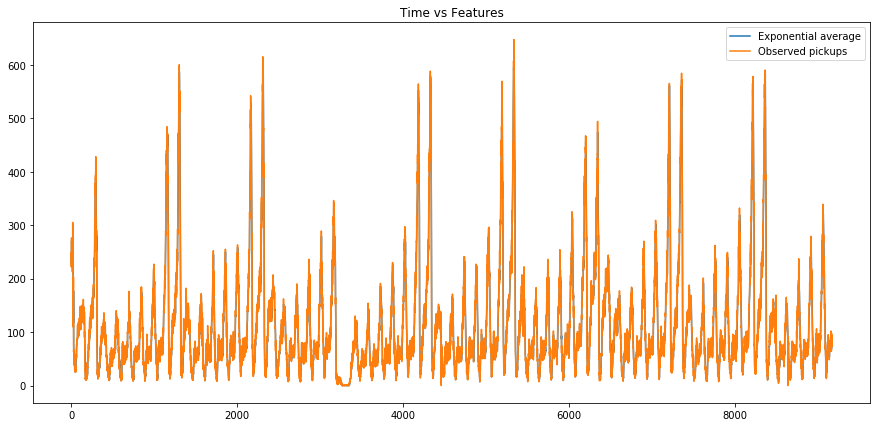

cluster  2


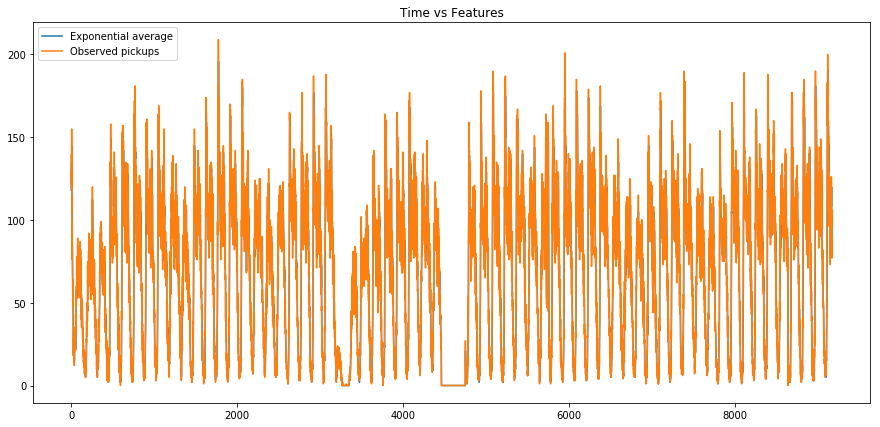

cluster  3


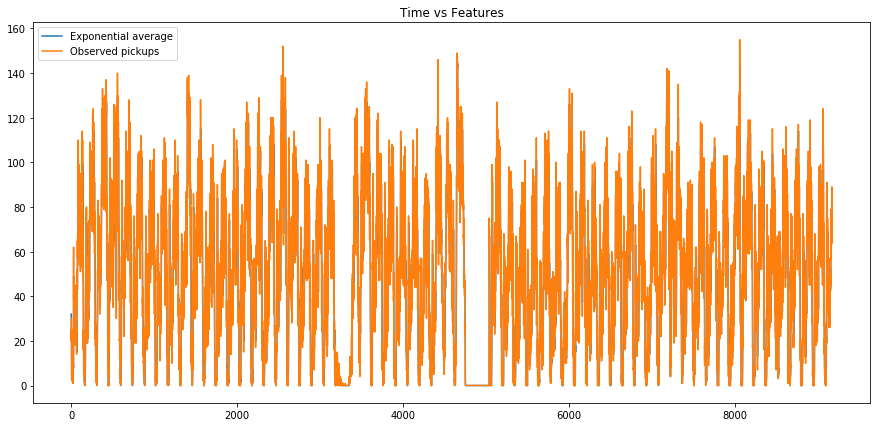

cluster  4


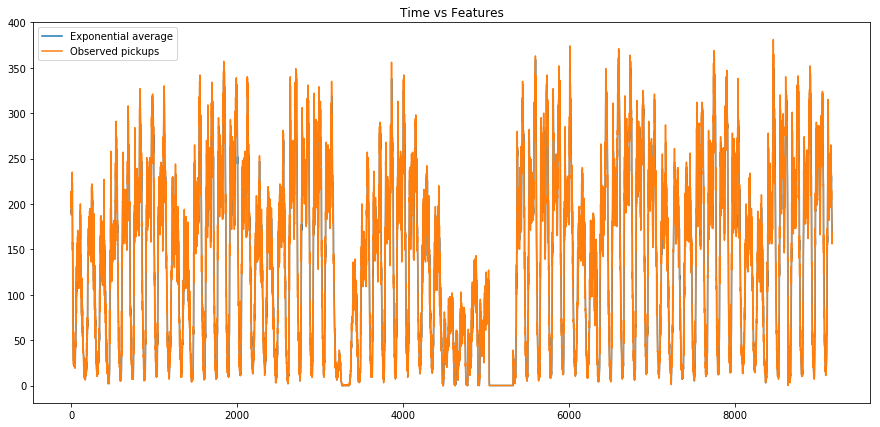

cluster  5


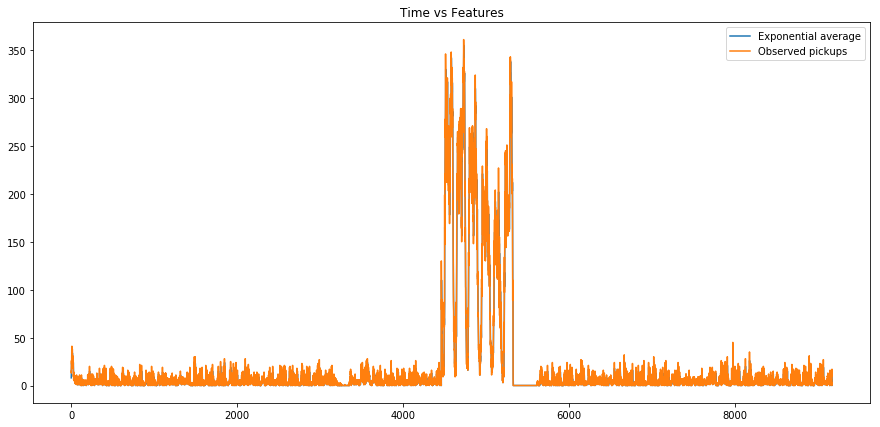

cluster  6


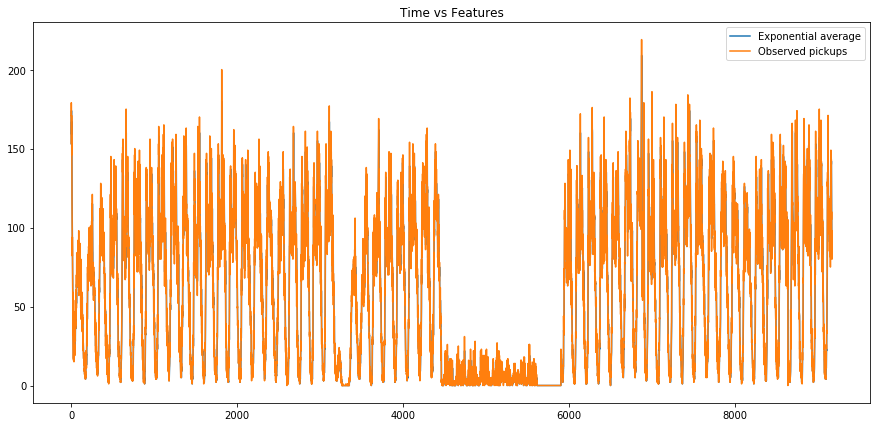

cluster  7


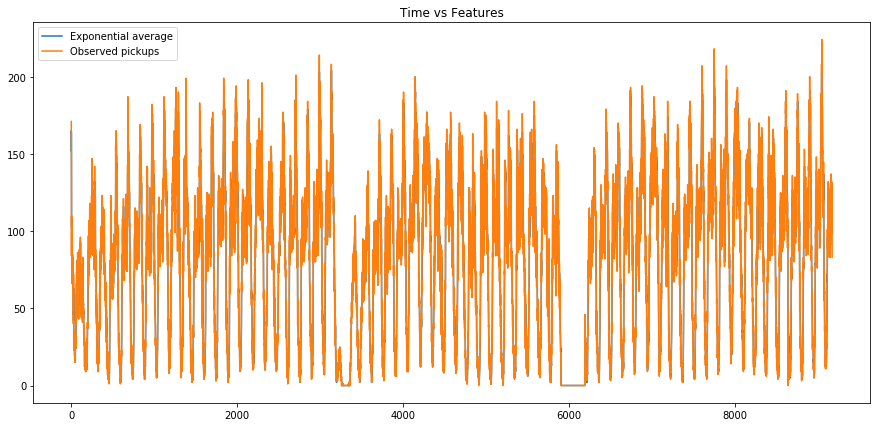

cluster  8


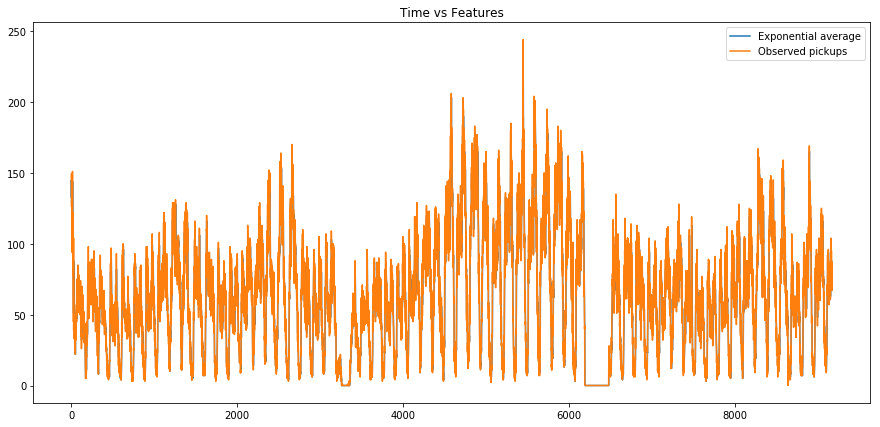

cluster  9


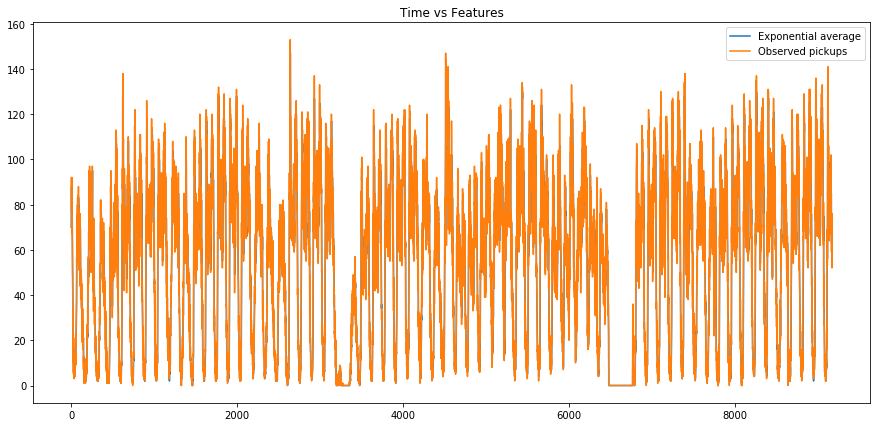

cluster  10


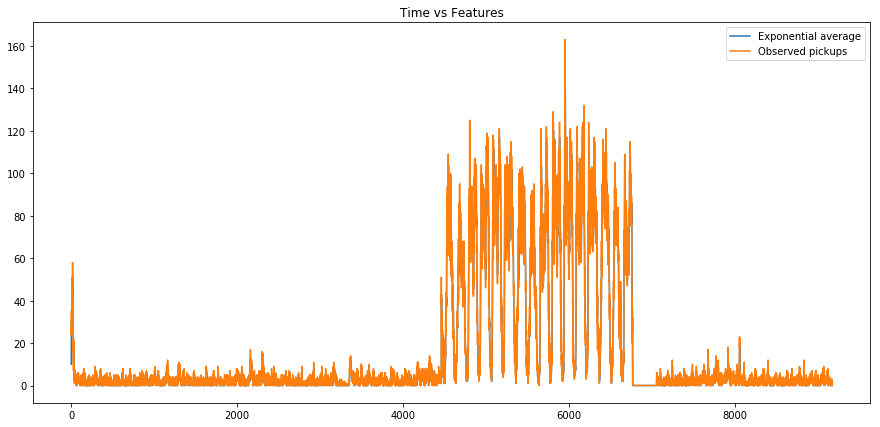

cluster  11


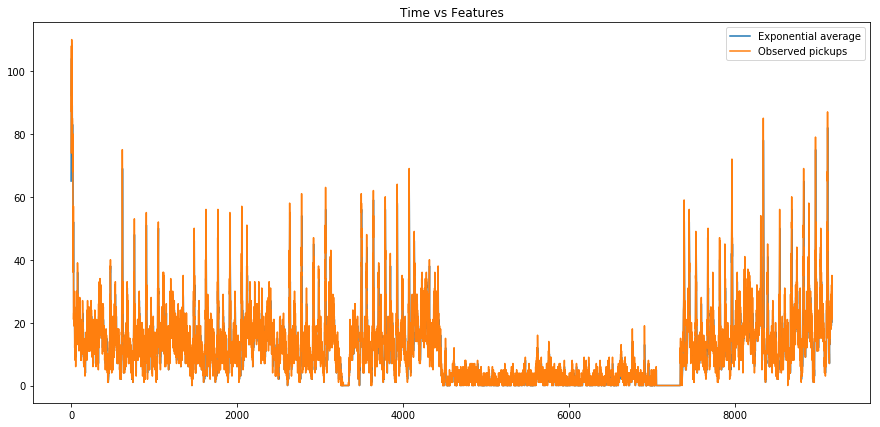

cluster  12


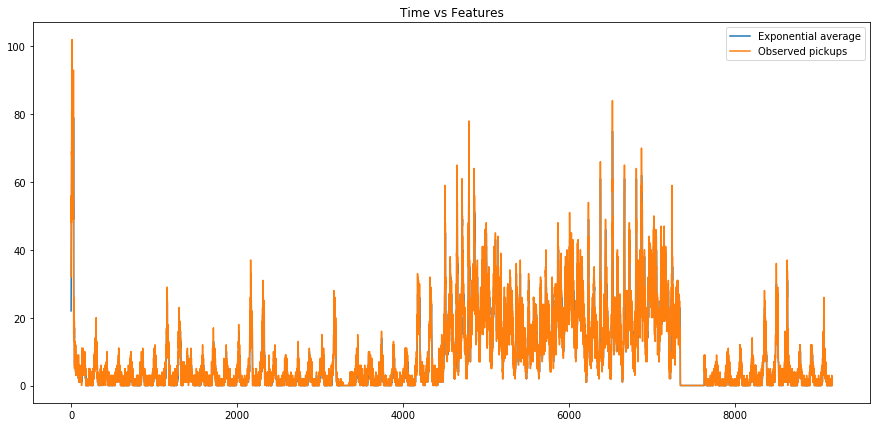

cluster  13


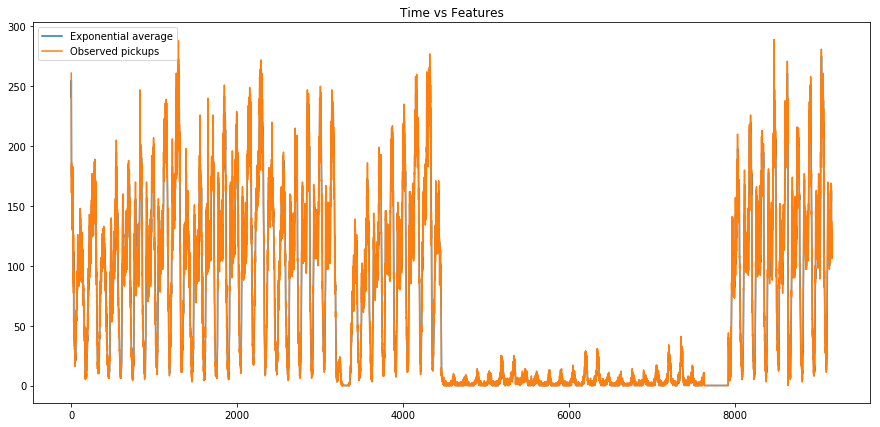

cluster  14


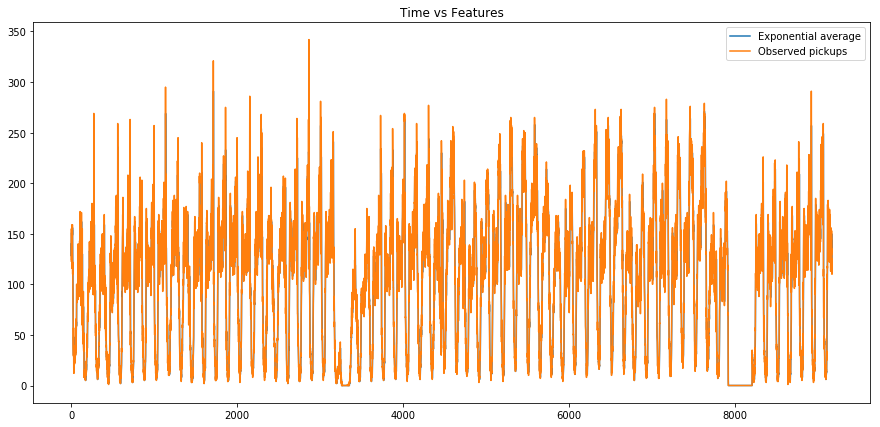

cluster  15


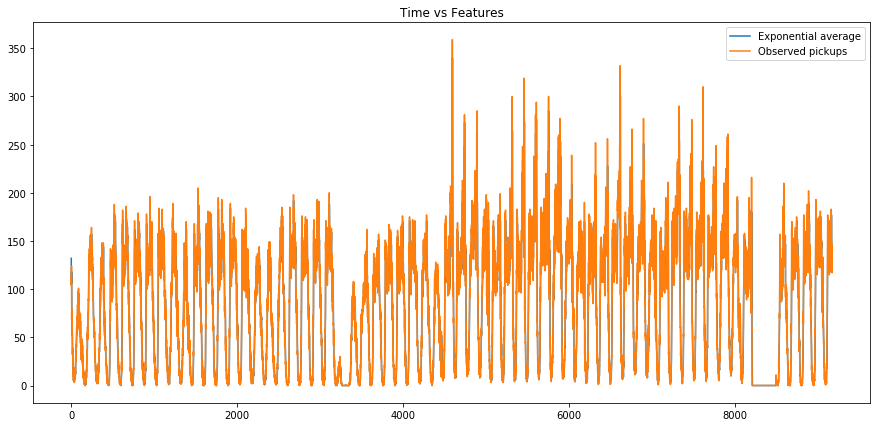

cluster  16


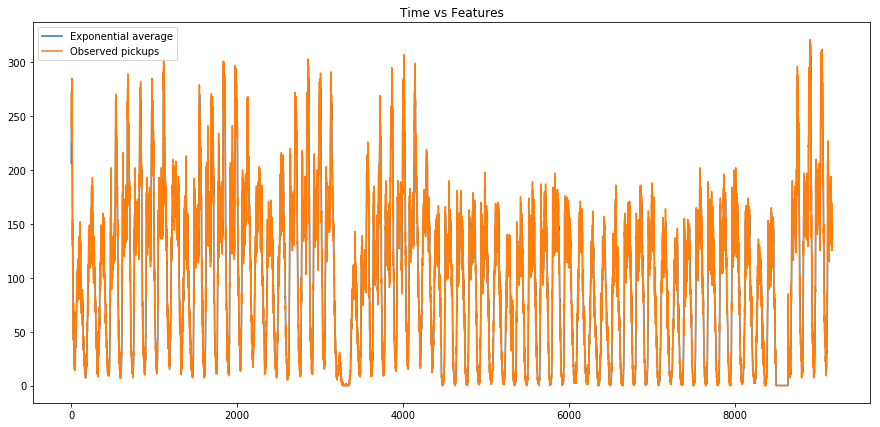

cluster  17


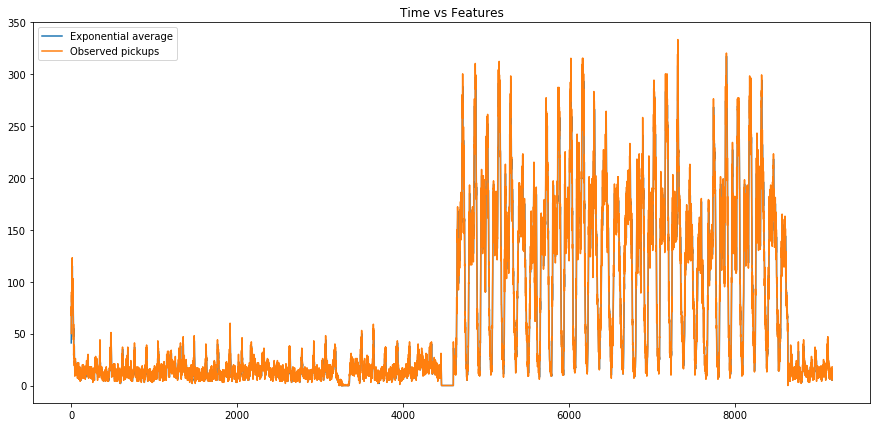

cluster  18


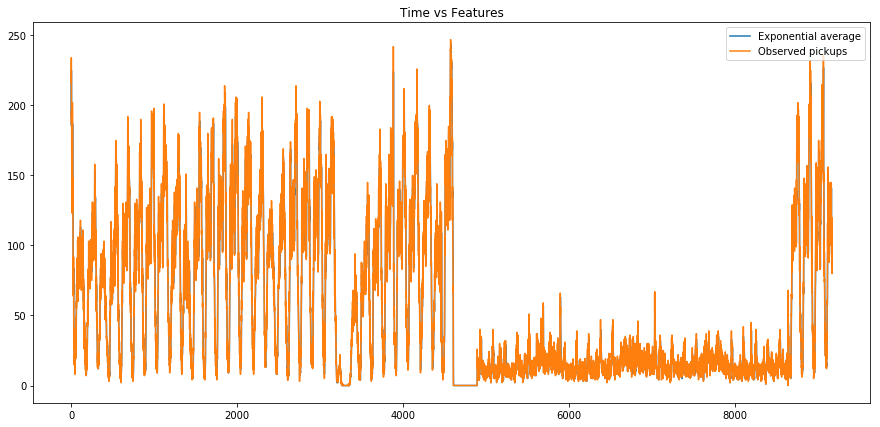

cluster  19


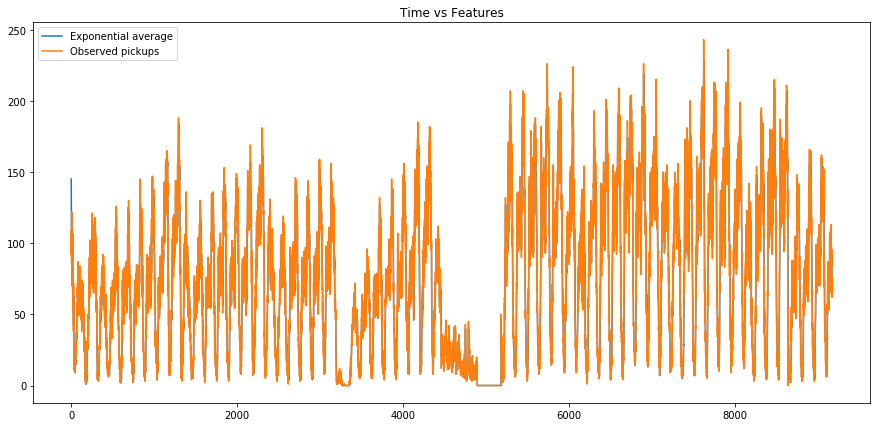

cluster  20


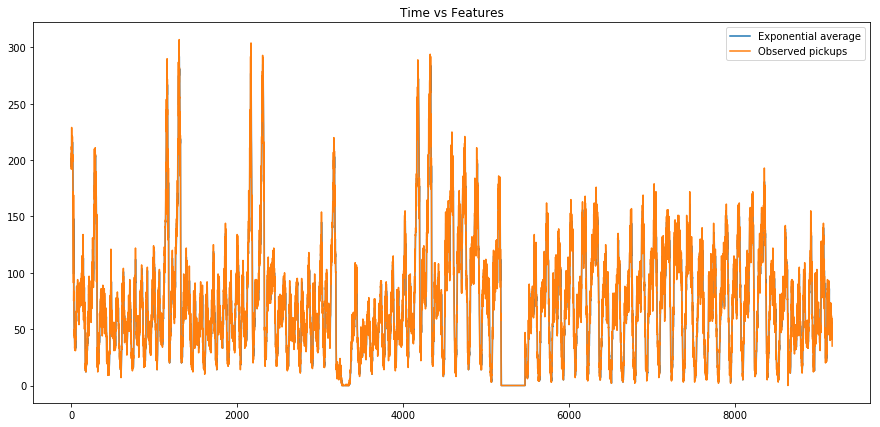

cluster  21


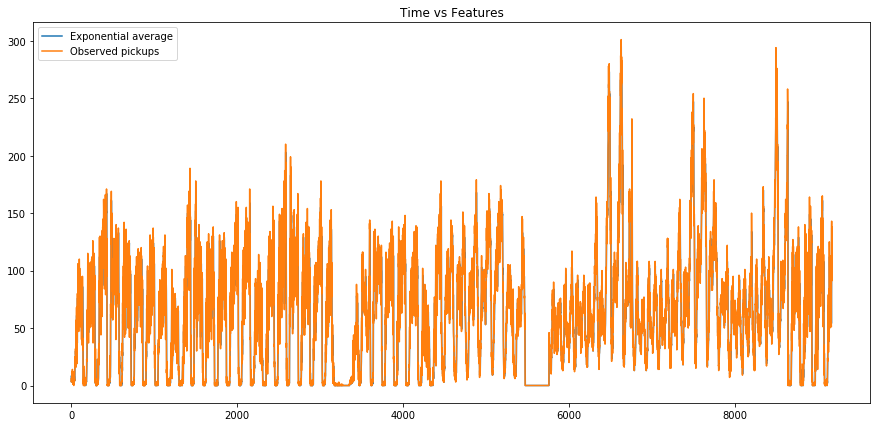

cluster  22


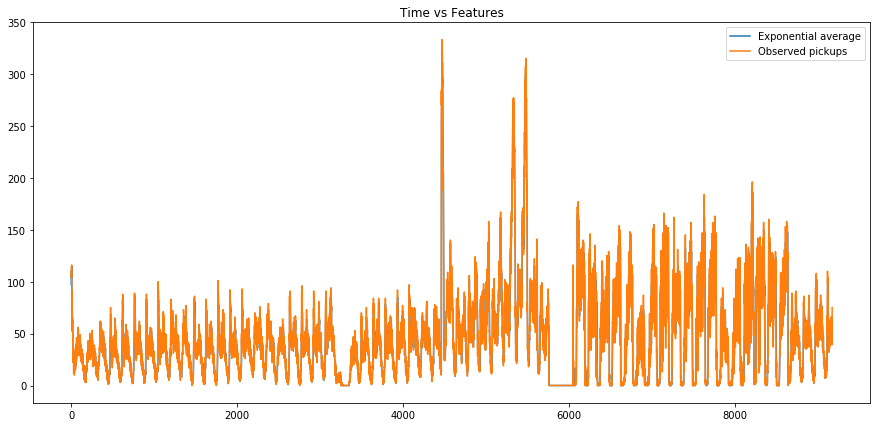

cluster  23


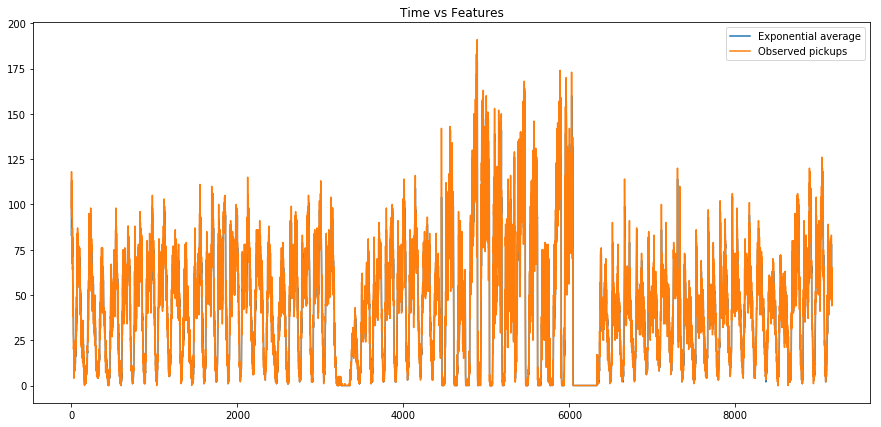

cluster  24


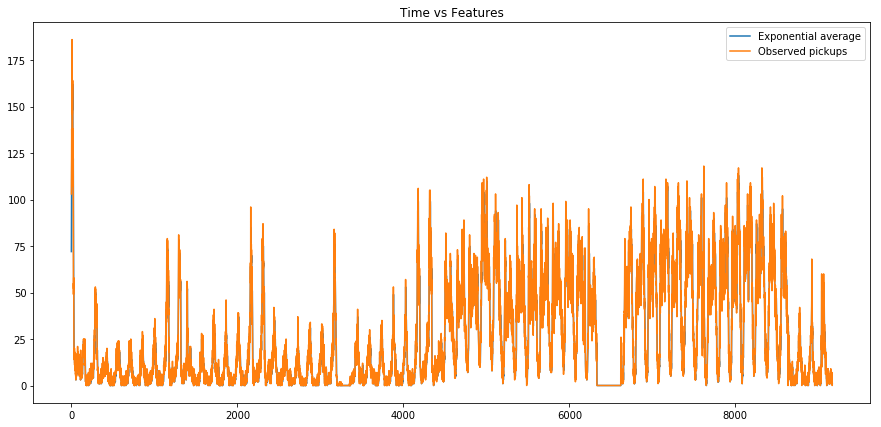

cluster  25


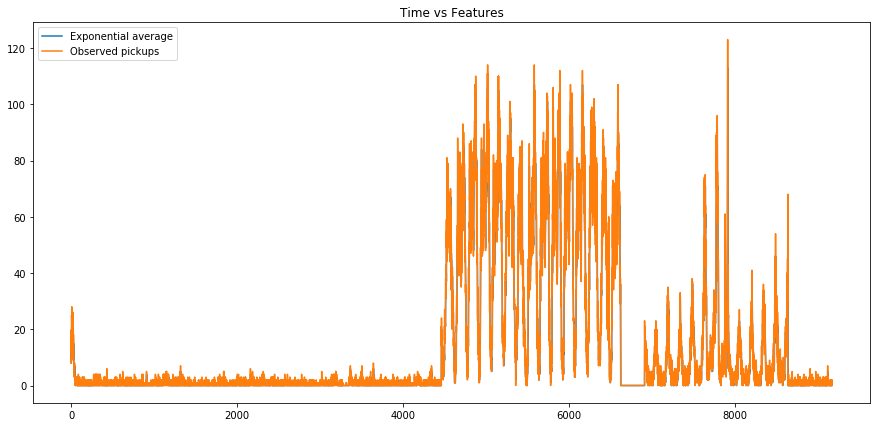

cluster  26


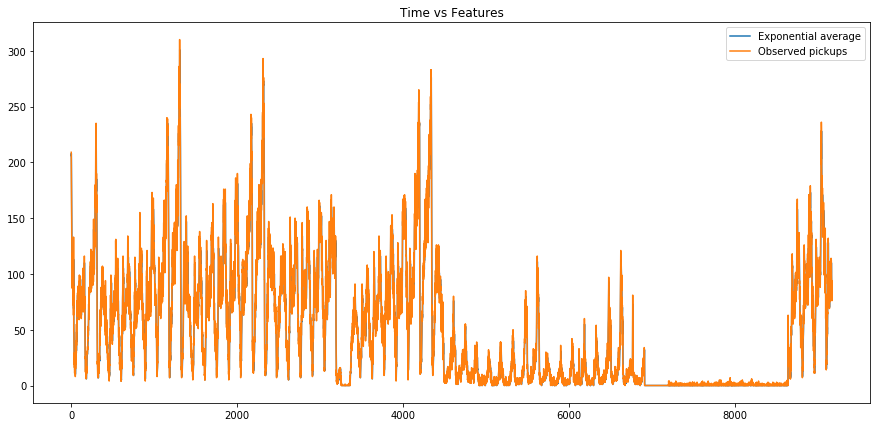

cluster  27


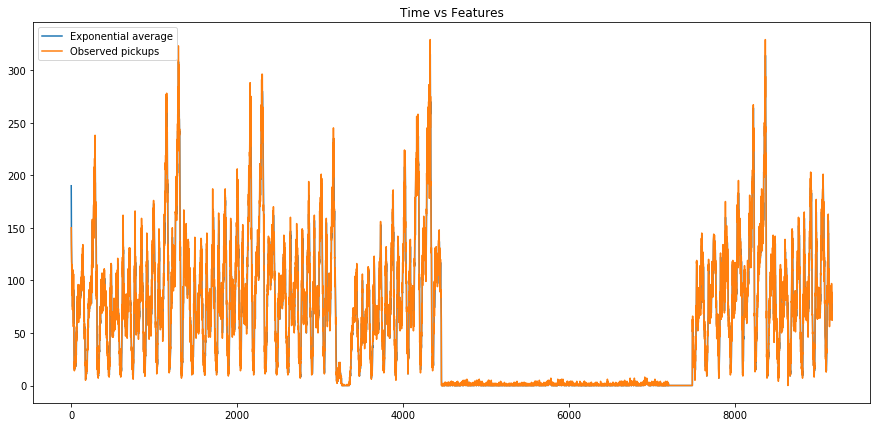

cluster  28


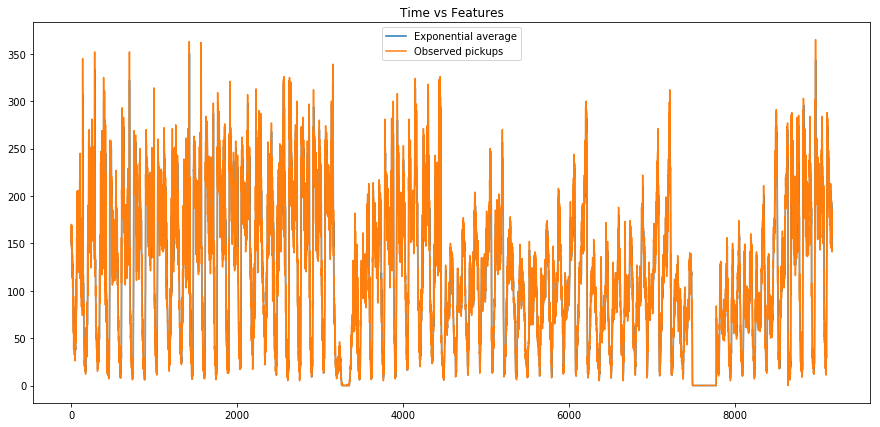

cluster  29


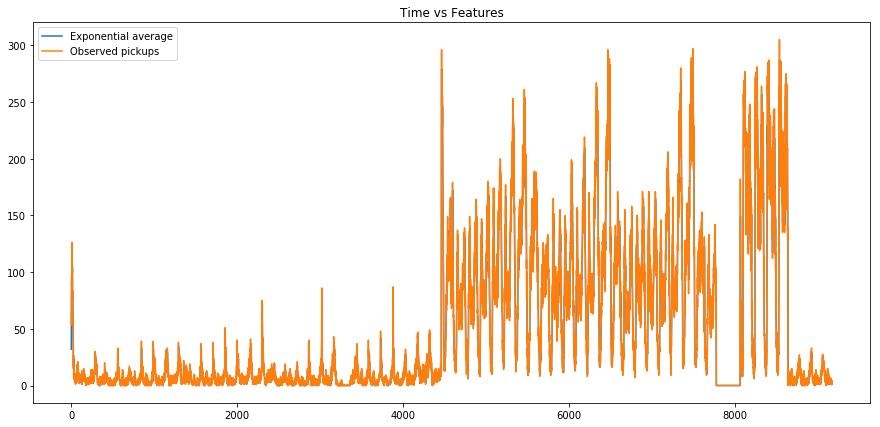

cluster  30


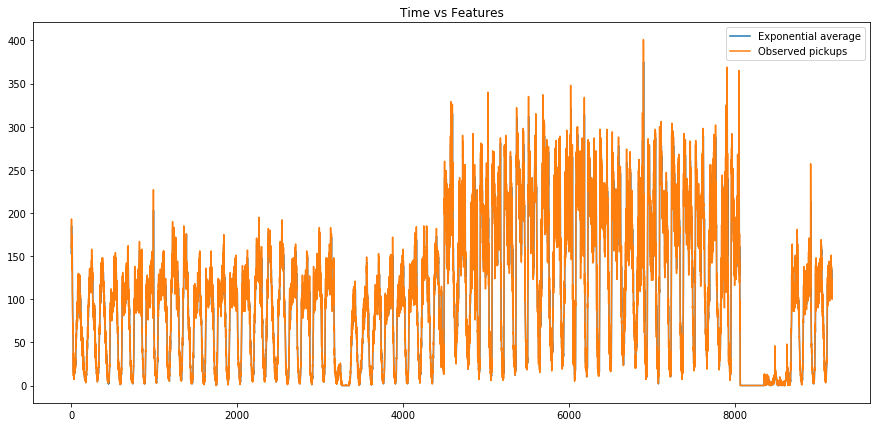

cluster  31


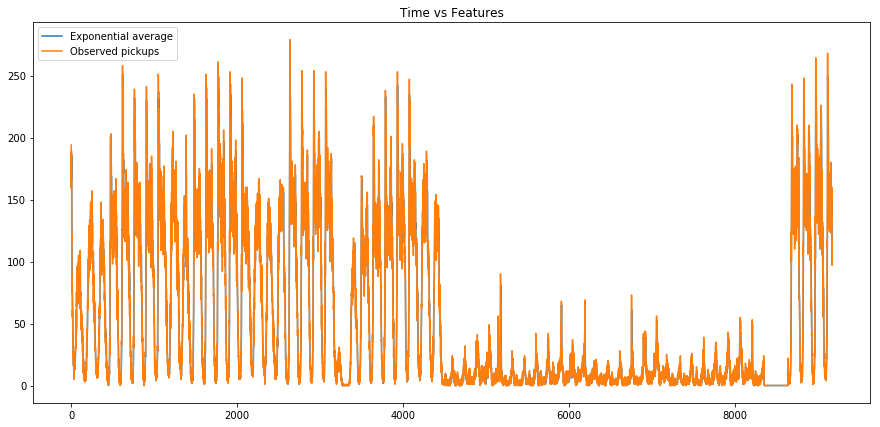

cluster  32


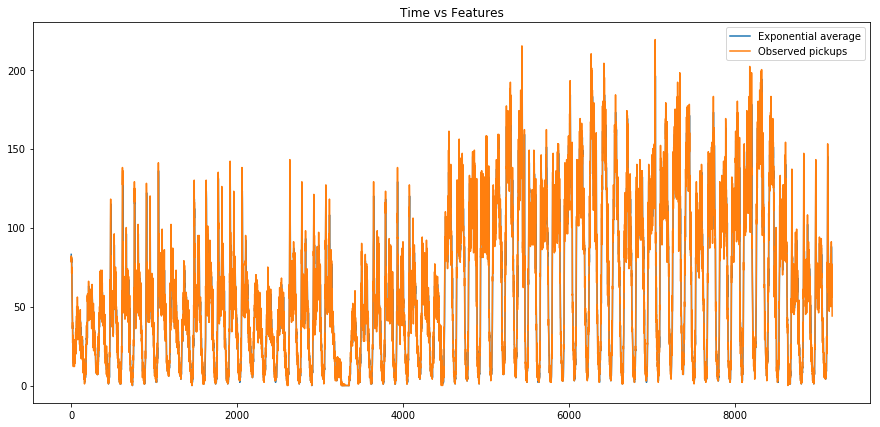

cluster  33


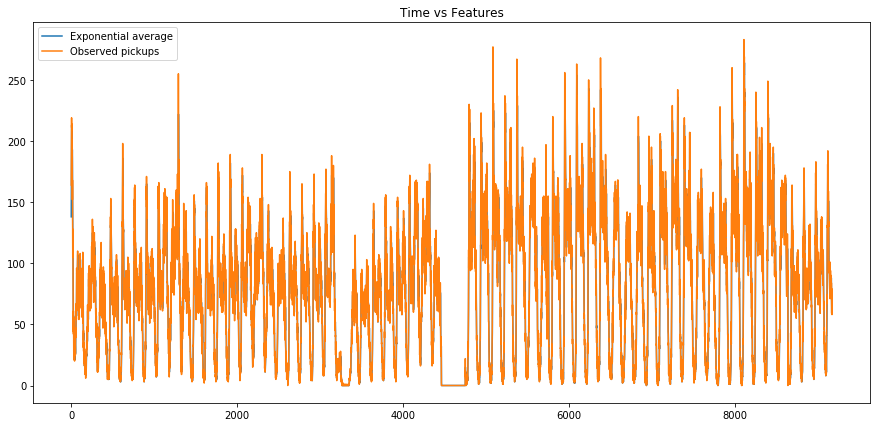

cluster  34


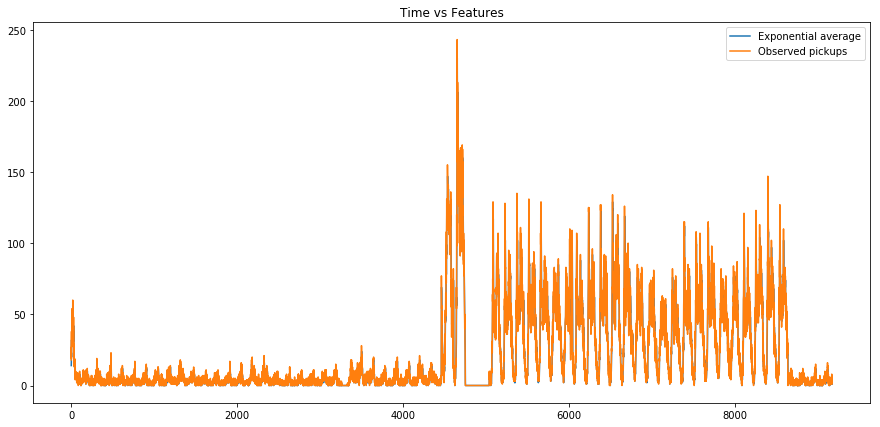

cluster  35


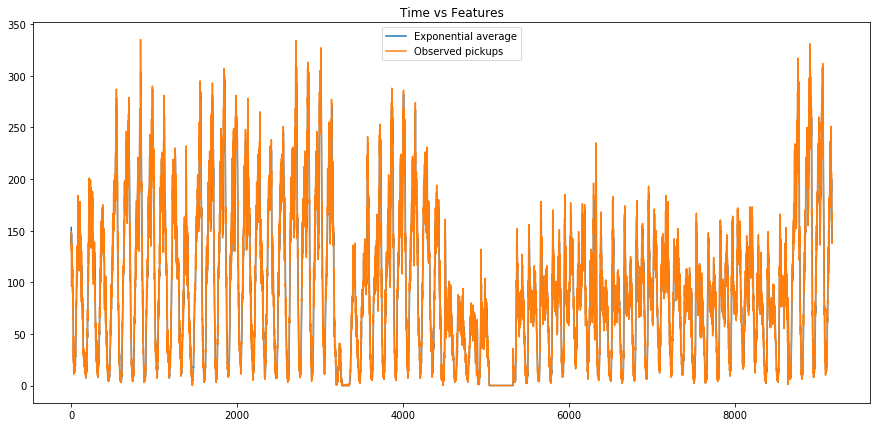

cluster  36


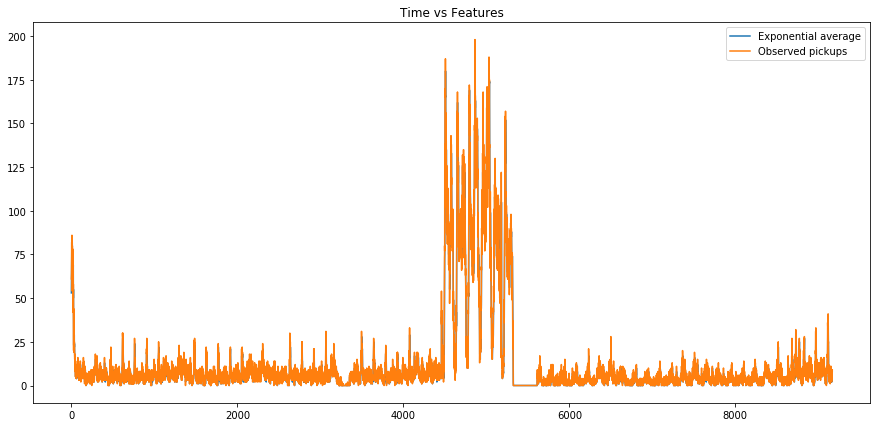

cluster  37


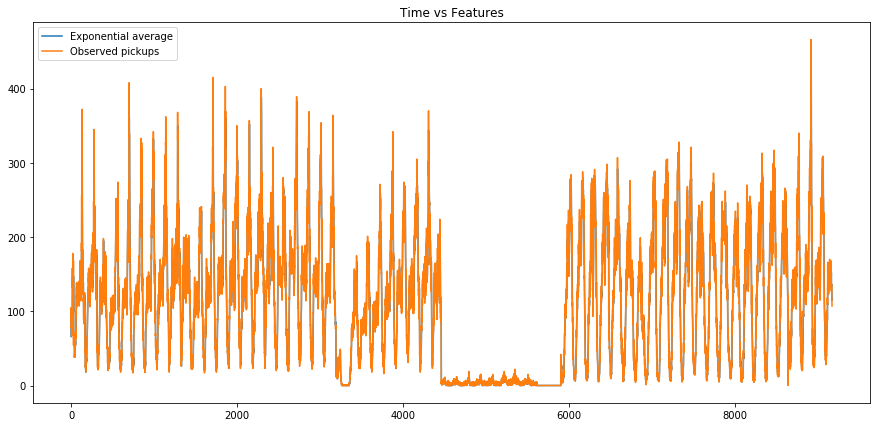

cluster  38


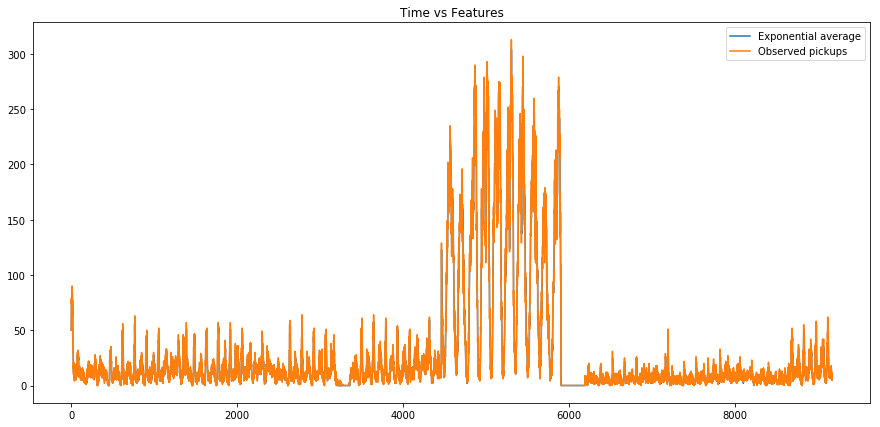

cluster  39


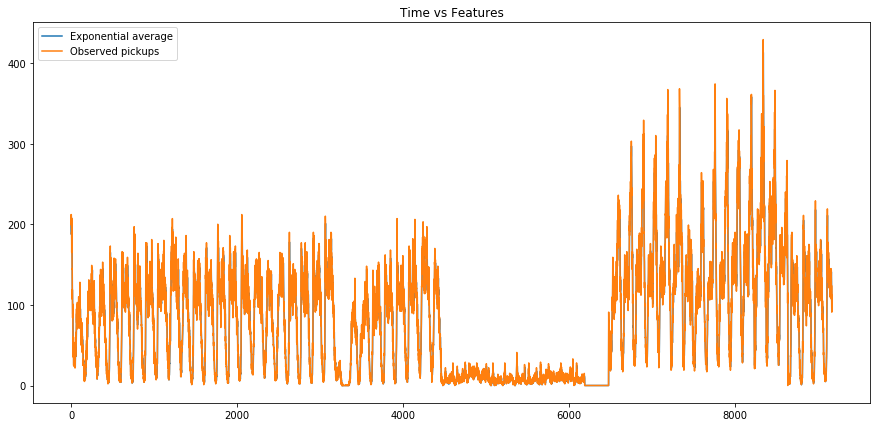

cluster  40


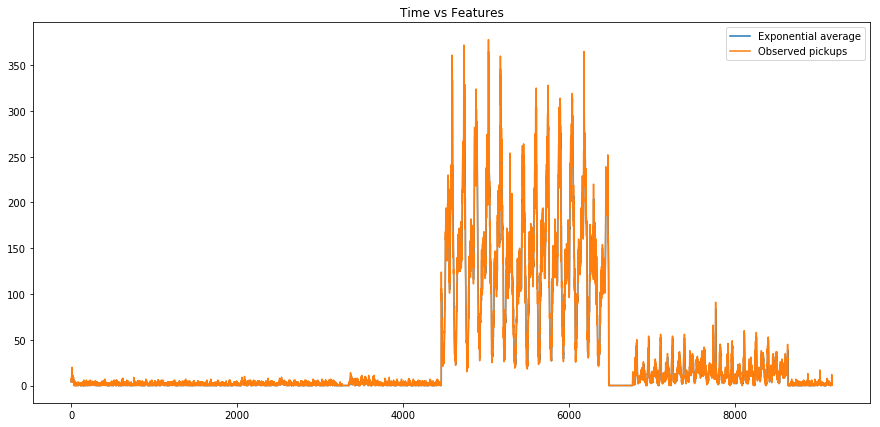

In [110]:
for i in range(40):
    print("cluster ",i+1)
    plt.figure(figsize=(15,7))
    plt.plot(list(range(0,9169)),df_train['exp_avg'][i*9169:9169*(i+1)], label='Exponential average')
    #plt.plot(list(range(0,9169)),df_train["ft_1"][i*9169:9169*(i+1)], label='ft_1')
    #plt.plot(list(range(0,9169)),df_train["ft_2"][i*9169:9169*(i+1)], label='ft_2')
    #plt.plot(list(range(0,9169)),df_train["ft_3"][i*9169:9169*(i+1)], label='ft_3')
    #plt.plot(list(range(0,9169)),df_train["ft_4"][i*9169:9169*(i+1)], label='ft_4')
    plt.plot(list(range(0,9169)),tsne_train_output[i*9169:9169*(i+1)], label='Observed pickups')
    plt.title("Time vs Features")
    plt.legend()
    plt.show()

#### Observations
    1. All the features are fairly overlapping.
    2. We find that for pickups in the range 5000 to 7000, the month of feb, the pickups are fairly low in some regions.
    3. But for in cluster 40, it's the opposite, the pickups are little higher.

### Using Linear Regression

In [189]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
lr_reg=LinearRegression().fit(df_train, tsne_train_output)
parameter_dict = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr_reg, param_grid=parameter_dict, cv=None)
grid.fit(df_train, tsne_train_output)

print("the best estimator obtained after grid search is as follows:",grid.best_estimator_)

the best estimator obtained after grid search is as follows: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


In [190]:
lr_reg=LinearRegression(copy_X=True, fit_intercept=True, normalize=True).fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

### Using Random Forest Regressor

In [194]:
from sklearn.model_selection import RandomizedSearchCV
regr1 = RandomForestRegressor()
param_dist = {"max_depth": [3, 5,None],"max_features": ['sqrt' , 'log2'],"min_samples_split": [2,3,4,5,6],"min_samples_leaf": [2,3,4,5,6,7],"n_estimators":[30,40,50]}

# run randomized search
search = 30
random_search = RandomizedSearchCV(regr1, param_distributions=param_dist,n_iter=search)
random_search.fit(df_train, tsne_train_output)


#Report= pd.DataFrame.from_dict(random_search.cv_results_)


In [200]:
print("the optimal paramters of Random forest for given data are: ",random_search.best_params_)

the optimal paramters of Random forest for given data are:  {'n_estimators': 30, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'log2', 'max_depth': None}


In [202]:
regr1 = RandomForestRegressor(max_features='log2',min_samples_leaf=7,min_samples_split=4,n_estimators=30, n_jobs=-1,max_depth=None)
regr1.fit(df_train, tsne_train_output)

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

### Using XgBoost Regressor

In [206]:
x_model = xgb.XGBRegressor()
param_dist = {"max_depth": [3,4,5,9],"min_child_weight": [3,4,5,6],"gamma":[0,0.1,0.2,0.3],"colsample_bytree":[0.7,0.8,0.9],"nthread":[3,4,5,6]}

# run randomized search
iterations = 30
random_search = RandomizedSearchCV(x_model, param_distributions=param_dist,n_iter=iterations)
random_search.fit(df_train, tsne_train_output)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=30, n_jobs=None,
          param_distributions={'max_depth': [3, 4, 5, 9], 'min_child_weight': [3, 4, 5, 6], 'gamma': [0, 0.1, 0.2, 0.3], 'colsample_bytree': [0.7, 0.8, 0.9], 'nthread': [3, 4, 5, 6]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [207]:
print("the optimal paramters of XGB regressor for given data are: ",random_search.best_params_)

the optimal paramters of XGB regressor for given data are:  {'nthread': 4, 'min_child_weight': 3, 'max_depth': 3, 'gamma': 0.1, 'colsample_bytree': 0.9}


In [208]:
x_model = xgb.XGBRegressor(learning_rate =0.1,n_estimators=1000,max_depth=3,min_child_weight=3,gamma=0.1,subsample=0.8,reg_alpha=200, reg_lambda=200,colsample_bytree=0.9,nthread=4)
x_model.fit(df_train, tsne_train_output)
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [209]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [210]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.13951687134721183       Test:  0.13599516019903538
Exponential Averages Forecasting -           Train:  0.13231694608887318       Test:  0.12899568877635068
Linear Regression -                         Train:  0.1327133167445527       Test:  0.12857588283632582
Random Forest Regression -                   Train:  0.10755982893189218      Test:  0.12488854276438775
XgBoost Regression -                         Train:  0.12843462999152014       Test:  0.1259694762118721
--------------------------------------------------------------------------------------------------------


In [207]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -                 MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -            MAPE: ",mean_err[5],"      MSE: ",median_err[5])
print ("--------------------------------------------------------------------------------------------------------")
print ("AutoRegressive Integrated Moving Average (2016 Values) MAPE: ",mape,"      MSE: ",error)
mean_err[6]=mape 
median_err[6]=error

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.18200214223211997       MSE:  388.41868279569894
Moving Averages (2016 Values) -                        MAPE:  0.14236755169126242        MSE:  177.4968077956989
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.17819112391088368       MSE:  375.2245799731183
Weighted Moving Averages (2016 Values) -               MAPE:  0.1348660662276155       MSE:  165.28621191756272
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -                 MAPE:  0.17745934058316823       MSE:  369.8939236111111
Exponential Moving Averages (2016 Values) -            MAPE:  0.1345

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


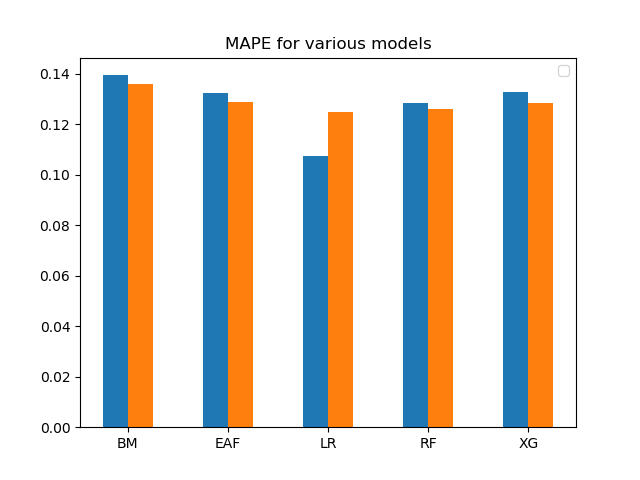

Blue bars: Train MAPE
Orange bars: Test MAPE


In [225]:
import numpy as np
import matplotlib.pyplot as plt

X = ["BM","EAF","LR","RF","XG"]
Y = train_mape
Z = test_mape

def subcategorybar(X, vals, width=0.5):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

subcategorybar(X, [Y,Z])
plt.title("MAPE for various models")
plt.legend()
plt.show()
print("Blue bars: Train MAPE""\n""Orange bars: Test MAPE")
#https://stackoverflow.com/questions/48157735/plot-multiple-bars-for-categorical-data

### Obervations:
    1. We have plotted train and test values for all machine learning models.
    
       BM=Baseline model
       EAF=Exponential average forecasting
       LR=Linear Regression
       RF=Random Forest
       XG= XGboost
       

<IPython.core.display.Javascript object>


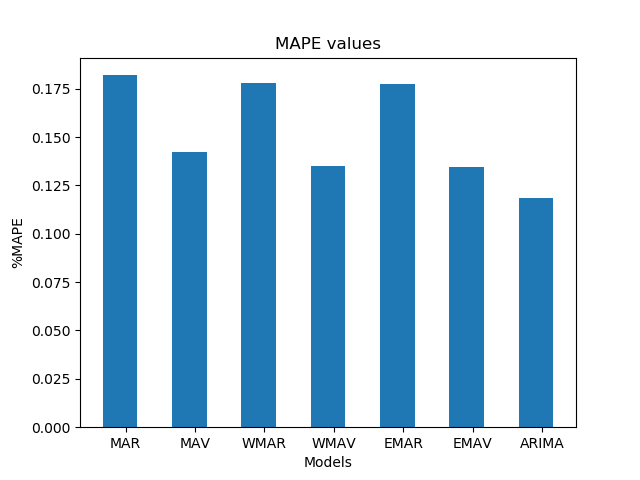

In [209]:
import matplotlib.pyplot as plt
data = {0: 0.18200214223211997, 1: 0.14236755169126242, 2: 0.17819112391088368, 3: 0.1348660662276155, 4: 0.17745934058316823, 5: 0.13451976413031697,6: 0.11829176030018547}
#plt.figure(figsize=(10,5))
bar_width = 0.5
plt.bar([x for x in data], [data[x] for x in data], bar_width)
plt.xticks([x+bar_width/6 for x in data], ('MAR','MAV','WMAR','WMAV','EMAR','EMAV','ARIMA'))
plt.title("MAPE values")
plt.ylabel("%MAPE")
plt.xlabel("Models")
plt.show()

## Summary

In [213]:
from prettytable import PrettyTable
#http://zetcode.com/python/prettytable/
    
x = PrettyTable()

x.field_names = ["MODEL","MAPE"]

""
"Weighted Moving Averages (Ratios"
""
")"
")"
"" 

x.add_row(["Moving Averages (Ratios)",np.round(mean_err[0],3)])
x.add_row(["Moving Averages (2016 Values)",np.round(mean_err[1],3)])
x.add_row(["Weighted Moving Averages (Ratios",np.round(mean_err[2],3)])
x.add_row(["Weighted Moving Averages (2016 Values)",np.round(mean_err[3],3)])
x.add_row(["Exponential Moving Averages (Ratios",np.round(mean_err[4],3)])
x.add_row(["Exponential Moving Averages (2016 Values)",np.round(mean_err[5],3)])
x.add_row(["AutoRegressive Integrated Moving Average (2016 Values)",np.round(mean_err[6],3)])
x.add_row(["Linear Regression", 0.128])
x.add_row(["XGBOOST",0.124])
x.add_row(["Random Forest",0.124])
                      



print(x)

+--------------------------------------------------------+-------+
|                         MODEL                          |  MAPE |
+--------------------------------------------------------+-------+
|                Moving Averages (Ratios)                | 0.182 |
|             Moving Averages (2016 Values)              | 0.142 |
|            Weighted Moving Averages (Ratios            | 0.178 |
|         Weighted Moving Averages (2016 Values)         | 0.135 |
|          Exponential Moving Averages (Ratios           | 0.177 |
|       Exponential Moving Averages (2016 Values)        | 0.135 |
| AutoRegressive Integrated Moving Average (2016 Values) | 0.118 |
|                   Linear Regression                    | 0.128 |
|                        XGBOOST                         | 0.124 |
|                     Random Forest                      | 0.124 |
+--------------------------------------------------------+-------+


#### we find that the best model obtained so far is ARIMA forecasting model with MAPE value of 11.82%

### Conclusion
    1. We've analysed and worked on the New york Taxi demand prediction case study.
    2. We've considered 2016 data for 3 months in the case study
    3. Initially We've performed EDA and removed all the outliers from the data.
    4. We've performed clustering using latitude and longitude of pickups with distance parameters.
    5. Similarly we obtain clustering for other months as well.
    6. We divide the points and classify them based on number of trips using time bins.
    7. We use fourier analysis to find frequencies and use the top 5 frequencies and amplitudes.
    8. We include other features such as past five pickup in last 50 minutes 
    9. Finally, we apply baseline models and regression models to get predictions of pickups in any 10 minute interval
    10. For reducing MAPE to less than 12% ,we've used arima model forecasting where we explained the steps in detail.
    